In [62]:
!pip install seaborn
!pip install tabulate


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from scipy.stats import pearsonr
from scipy.stats import f_oneway  
from IPython.display import display
from scipy.stats import ttest_ind


In [64]:
sales_df = pd.read_csv('/Users/nguyenthuan/Sales_Data.csv')
promo_df = pd.read_csv('/Users/nguyenthuan/Promotion.csv')
sales_df


,Unnamed: 0,Date,New_Sales
0,0,1995-01-01,801.087735
1,1,1995-02-01,1109.019328
2,2,1995-03-01,876.561180
3,3,1995-04-01,890.258213
4,4,1995-05-01,774.015130
...,...,...,...
355,355,2024-08-01,1607.835902
356,356,2024-09-01,1644.318122
357,357,2024-10-01,1662.271517
358,358,2024-11-01,2884.201446


In [65]:
promo_df

,Promo_ID,Active_Month,Promo_Type,Budget_USD
0,P001,1995-02,Bundle,7000
1,P002,1995-08,Bundle,22000
2,P003,1995-12,Discount,6000
3,P004,1997-10,Bundle,20000
4,P005,1997-11,Discount,5000
5,P006,1998-08,Discount,19000
6,P007,1999-03,Bundle,21000
7,P008,1999-05,Bundle,8000
8,P009,1999-06,Discount,7000
9,P010,1999-08,Discount,21000


## **Understand the Dataset**

In [66]:
def check_df_types(df):
    print("== Column Types ==")
    print(df.dtypes)
    print("\n== Number of unique values per column ==")
    print(df.nunique())
    print("\n== Null values per column ==")
    print(df.isnull().sum())

In [67]:
check_df_types(promo_df)

== Column Types ==
Promo_ID        object
Active_Month    object
Promo_Type      object
Budget_USD       int64
dtype: object

== Number of unique values per column ==
Promo_ID        54
Active_Month    54
Promo_Type       3
Budget_USD      16
dtype: int64

== Null values per column ==
Promo_ID        0
Active_Month    0
Promo_Type      0
Budget_USD      0
dtype: int64


In [68]:
check_df_types(sales_df)

== Column Types ==
Unnamed: 0      int64
Date           object
New_Sales     float64
dtype: object

== Number of unique values per column ==
Unnamed: 0    360
Date          360
New_Sales     360
dtype: int64

== Null values per column ==
Unnamed: 0    0
Date          0
New_Sales     0
dtype: int64


**TÓM LẠI**

1. Đối với Sales_df, date đang dạng chuỗi phải chuyển thành datetime, tạo thêm cột Year, Month (dể hỗ trợ phân tích theo năm, mùa, vụ), YearMonth(để gộp vs dữ liệu promo_df)
2. Đối với promo_df: active_month phải chuyển về date time, đồng thời tạo thêm cột YearMonth


In [69]:
#clean sales
#Chuyển cột Date từ kiểu chuỗi (object) sang định dạng thời gian
sales_df['Date'] = pd.to_datetime(sales_df['Date'])
#Tạo cột mới Year chứa năm (yyyy) từ cột Date
sales_df['Year'] = sales_df['Date'].dt.year
#Tạo cột mới Month chứa tháng (mm) từ cột Date
sales_df['Month'] = sales_df['Date'].dt.month
# Tạo cột YearMonth dạng YYYY-MM từ Date, đây là khoá thời gian chính để merged với promo_df
sales_df['YearMonth'] = sales_df['Date'].dt.to_period('M').astype(str)
sales_df

,Unnamed: 0,Date,New_Sales,Year,Month,YearMonth
0,0,1995-01-01,801.087735,1995,1,1995-01
1,1,1995-02-01,1109.019328,1995,2,1995-02
2,2,1995-03-01,876.561180,1995,3,1995-03
3,3,1995-04-01,890.258213,1995,4,1995-04
4,4,1995-05-01,774.015130,1995,5,1995-05
...,...,...,...,...,...,...
355,355,2024-08-01,1607.835902,2024,8,2024-08
356,356,2024-09-01,1644.318122,2024,9,2024-09
357,357,2024-10-01,1662.271517,2024,10,2024-10
358,358,2024-11-01,2884.201446,2024,11,2024-11


In [70]:
#Chuyển cột Active_Month từ dạng chuỗi (object) → về định dạng thời gian chuẩn datetime.
promo_df['Active_Month'] = pd.to_datetime(promo_df['Active_Month'])
#Đồng bộ định dạng thời gian với sales_df['YearMonth']
promo_df['YearMonth'] = promo_df['Active_Month'].dt.to_period('M').astype(str)
promo_df

,Promo_ID,Active_Month,Promo_Type,Budget_USD,YearMonth
0,P001,1995-02-01,Bundle,7000,1995-02
1,P002,1995-08-01,Bundle,22000,1995-08
2,P003,1995-12-01,Discount,6000,1995-12
3,P004,1997-10-01,Bundle,20000,1997-10
4,P005,1997-11-01,Discount,5000,1997-11
5,P006,1998-08-01,Discount,19000,1998-08
6,P007,1999-03-01,Bundle,21000,1999-03
7,P008,1999-05-01,Bundle,8000,1999-05
8,P009,1999-06-01,Discount,7000,1999-06
9,P010,1999-08-01,Discount,21000,1999-08


In [71]:
merged_df = pd.merge(sales_df, promo_df, on='YearMonth', how='left')

# Xử lý các giá trị NaN sau khi merge
merged_df['Promo_ID'] = merged_df['Promo_ID'].fillna('None')
merged_df['Promo_Type'] = merged_df['Promo_Type'].fillna('Non_Promo')
merged_df['Budget_USD'] = merged_df['Budget_USD'].fillna(0)

# Xoá cột dư nếu có
merged_df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')

merged_df["Date"] = pd.to_datetime(merged_df["Date"])  # nếu chưa convert
merged_df.set_index("Date", inplace=True)

merged_df

,New_Sales,Year,Month,YearMonth,Promo_ID,Active_Month,Promo_Type,Budget_USD
Date,,,,,,,,
1995-01-01,801.087735,1995,1,1995-01,None,NaT,Non_Promo,0.0
1995-02-01,1109.019328,1995,2,1995-02,P001,1995-02-01,Bundle,7000.0
1995-03-01,876.561180,1995,3,1995-03,None,NaT,Non_Promo,0.0
1995-04-01,890.258213,1995,4,1995-04,None,NaT,Non_Promo,0.0
1995-05-01,774.015130,1995,5,1995-05,None,NaT,Non_Promo,0.0
...,...,...,...,...,...,...,...,...
2024-08-01,1607.835902,2024,8,2024-08,None,NaT,Non_Promo,0.0
2024-09-01,1644.318122,2024,9,2024-09,None,NaT,Non_Promo,0.0
2024-10-01,1662.271517,2024,10,2024-10,None,NaT,Non_Promo,0.0


In [72]:
merged_df.to_csv("merged_df_export.csv", index=False)


In [73]:
def check_df_types(df):

    result = []

    for col in df.columns:
        dtype = df[col].dtype

        # Phân loại kiểu dữ liệu chính
        if pd.api.types.is_numeric_dtype(df[col]):
            general_type = "Numeric"
        elif pd.api.types.is_datetime64_any_dtype(df[col]):
            general_type = "Datetime"
        elif pd.api.types.is_string_dtype(df[col]):
            general_type = "String"
        elif pd.api.types.is_categorical_dtype(df[col]):
            general_type = "Category"
        elif pd.api.types.is_bool_dtype(df[col]):
            general_type = "Boolean"
        else:
            general_type = "Other"

        result.append({
            'Column': col,
            'Pandas dtype': str(dtype),
            'General Type': general_type,
            'Nulls': df[col].isnull().sum(),
            'Unique Values': df[col].nunique()
        })

    return pd.DataFrame(result)
type_summary = check_df_types(merged_df)
type_summary

,Column,Pandas dtype,General Type,Nulls,Unique Values
0,New_Sales,float64,Numeric,0,360
1,Year,int32,Numeric,0,30
2,Month,int32,Numeric,0,12
3,YearMonth,object,String,0,360
4,Promo_ID,object,String,0,55
5,Active_Month,datetime64[ns],Datetime,306,54
6,Promo_Type,object,String,0,4
7,Budget_USD,float64,Numeric,0,17


## **Summarize the Data**

In [74]:
def summarize_numerical_columns(df, exclude_cols=['Year', 'Month'], percentiles=[0.25, 0.5, 0.75]):
    """
    Tóm tắt thống kê cho các cột số, loại trừ các cột định danh như 'Year', 'Month'
    """
    numeric_cols = df.select_dtypes(include='number').drop(columns=exclude_cols, errors='ignore')
    summary = pd.DataFrame(index=numeric_cols.columns)

    summary['Mean'] = numeric_cols.mean()
    summary['Median'] = numeric_cols.median()
    summary['Mode'] = numeric_cols.mode().iloc[0]
    summary['Std'] = numeric_cols.std()
    summary['Variance'] = numeric_cols.var()
    summary['Min'] = numeric_cols.min()
    summary['Max'] = numeric_cols.max()

    for p in percentiles:
        summary[f'Percentile_{int(p*100)}'] = numeric_cols.quantile(p)

    return summary.round(2)



In [75]:
summary_stats = summarize_numerical_columns(merged_df)
summary_stats.style.format("{:.2f}").set_caption("Summary Statistics").background_gradient(cmap='Blues')


,Mean,Median,Mode,Std,Variance,Min,Max,Percentile_25,Percentile_50,Percentile_75
New_Sales,1248.31,1184.04,555.65,427.47,182731.57,555.65,3404.43,920.48,1184.04,1479.07
Budget_USD,2169.44,0.00,0.00,5661.94,32057559.58,0.00,24000.00,0.00,0.00,0.00


## **Univariate Analysis**

In [76]:

def univariate_sales_and_budget_analysis(df, bins=30):
    """
    Hiển thị:
    1. Distribution của New_Sales (tất cả tháng)
    2. Distribution của Budget_USD (chỉ các tháng có promo)
    """
    
    # --- 1. New_Sales (toàn bộ) ---
    col_sales = 'New_Sales'
    print(f"\n Tổng quan: {col_sales} (Toàn bộ dữ liệu)")
    print("-" * 50)
    print(f"Mean: {df[col_sales].mean():.2f}")
    print(f"Median: {df[col_sales].median():.2f}")
    print(f"Std: {df[col_sales].std():.2f}")
    print(f"Min: {df[col_sales].min():.2f}")
    print(f"Max: {df[col_sales].max():.2f}")
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(df[col_sales], bins=bins, kde=True, color='steelblue')
    plt.title('Distribution of New_Sales')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col_sales], color='salmon')
    plt.title('Boxplot of New_Sales')
    plt.tight_layout()
    plt.show()

    # --- 2. Budget_USD (chỉ tháng có promo) ---
    promo_df = df[df['Promo_Type'] != 'Non_Promo']
    col_budget = 'Budget_USD'
    
    print(f"\nTổng quan: {col_budget} (Chỉ tháng có promo)")
    print("-" * 50)
    print(f"Mean: {promo_df[col_budget].mean():.2f}")
    print(f"Median: {promo_df[col_budget].median():.2f}")
    print(f"Std: {promo_df[col_budget].std():.2f}")
    print(f"Min: {promo_df[col_budget].min():.2f}")
    print(f"Max: {promo_df[col_budget].max():.2f}")
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(promo_df[col_budget], bins=bins, kde=True, color='green')
    plt.title('Distribution of Budget (Promo Only)')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=promo_df[col_budget], color='orange')
    plt.title('Boxplot of Budget (Promo Only)')
    plt.tight_layout()
    plt.show()





 Tổng quan: New_Sales (Toàn bộ dữ liệu)
--------------------------------------------------
Mean: 1248.31
Median: 1184.04
Std: 427.47
Min: 555.65
Max: 3404.43


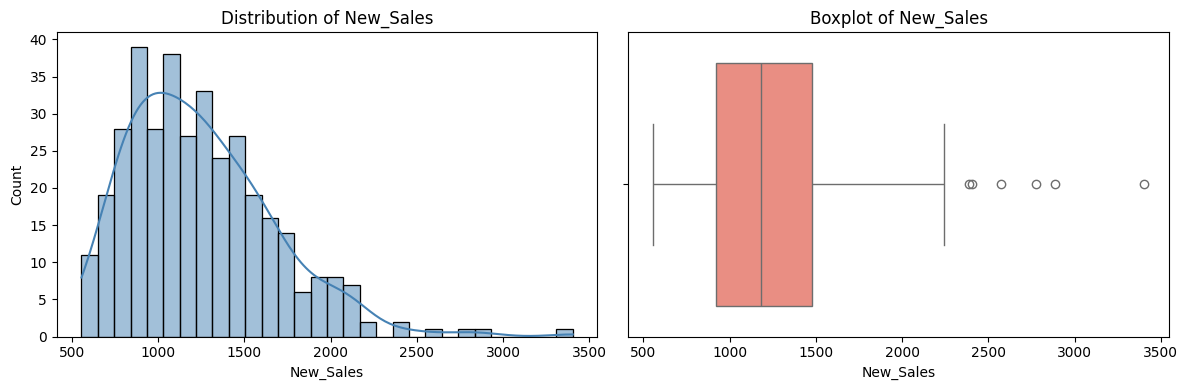


Tổng quan: Budget_USD (Chỉ tháng có promo)
--------------------------------------------------
Mean: 14462.96
Median: 16000.00
Std: 5999.10
Min: 5000.00
Max: 24000.00


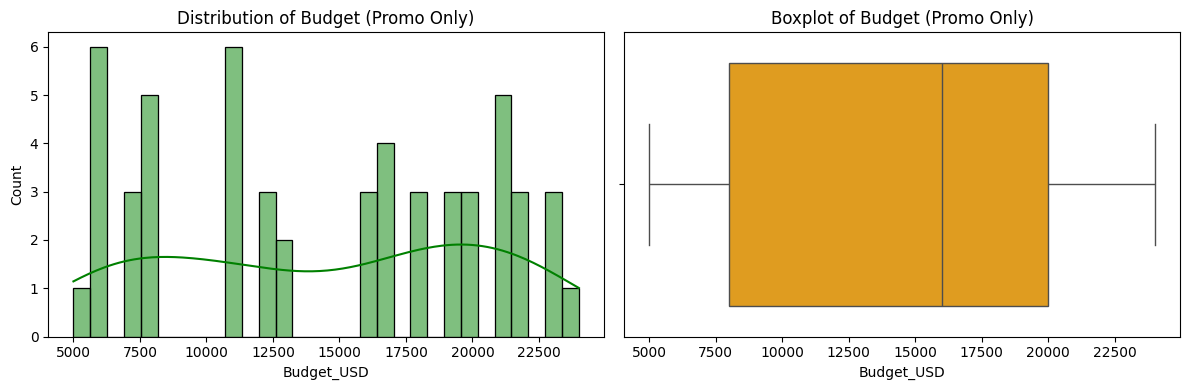

In [77]:
univariate_sales_and_budget_analysis(merged_df)


In [78]:
import pandas as pd

# Đảm bảo Budget là số
merged_df['Budget_USD'] = pd.to_numeric(merged_df['Budget_USD'], errors='coerce')

# Gộp theo năm và tính tổng ngân sách mỗi năm
annual_budget = (
    merged_df.groupby('Year')['Budget_USD']
    .sum()
    .reset_index()
    .rename(columns={'Budget_USD': 'Total_Budget'})
)

# Tính trung bình ngân sách 1 năm
avg_annual_budget = annual_budget['Total_Budget'].mean()

# In kết quả
print(f"Trung bình ngân sách khuyến mãi mỗi năm: {avg_annual_budget:,.2f} USD")


Trung bình ngân sách khuyến mãi mỗi năm: 26,033.33 USD


In [79]:
import pandas as pd

# Lọc chỉ các dòng có khuyến mãi thực sự
promo_df = merged_df[merged_df['Promo_Type'] != 'Non_Promo'].copy()

# Đảm bảo Budget là số
promo_df['Budget_USD'] = pd.to_numeric(promo_df['Budget_USD'], errors='coerce')

# Loại bỏ những dòng budget bị null hoặc bằng 0
valid_promos = promo_df[promo_df['Budget_USD'] > 0]

# Tính ngân sách trung bình mỗi chương trình
avg_budget_per_promo = valid_promos['Budget_USD'].mean()

# In kết quả
print(f"Ngân sách trung bình mỗi chương trình khuyến mãi: {avg_budget_per_promo:,.2f} USD")


Ngân sách trung bình mỗi chương trình khuyến mãi: 14,462.96 USD


In [80]:

df = merged_df.copy()

# Tính IQR
Q1 = df['New_Sales'].quantile(0.25)
Q3 = df['New_Sales'].quantile(0.75)
IQR = Q3 - Q1

# Xác định ngưỡng
upper_bound = Q3 + 1.5 * IQR

# Lọc các outliers (chỉ xét outlier phía trên vì doanh số cao)
outliers = df[df['New_Sales'] > upper_bound].copy()

# Thêm Label để dễ nhìn
outliers['Label'] = outliers['Year'].astype(str) + '-' + outliers['Month'].astype(str).str.zfill(2)

# Hiển thị các cột quan trọng
outlier_display = outliers[['Label', 'New_Sales', 'Promo_Type']]
print("Các outlier (doanh số cao bất thường):")
print(outlier_display.sort_values(by='New_Sales', ascending=False))


Các outlier (doanh số cao bất thường):
              Label    New_Sales Promo_Type
Date                                       
2024-04-01  2024-04  3404.428595   Cashback
2024-11-01  2024-11  2884.201446   Discount
2023-01-01  2023-01  2778.822869     Bundle
2022-01-01  2022-01  2574.493721     Bundle
2021-02-01  2021-02  2405.110869     Bundle
2016-01-01  2016-01  2388.768164   Discount


/var/folders/rh/0r4k_tw56sd9fl7wsl3tjh1m0000gn/T/ipykernel_45297/455494239.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=merged_df, x='Promo_Type', palette='Set2')


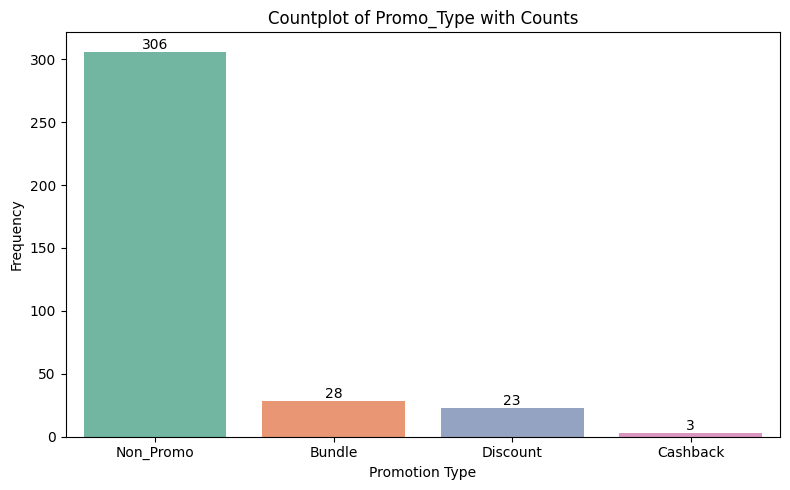

In [81]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=merged_df, x='Promo_Type', palette='Set2')

# Thêm số đếm trên mỗi cột
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', 
            (p.get_x() + p.get_width() / 2., height), 
            ha='center', va='bottom', fontsize=10)

plt.title('Countplot of Promo_Type with Counts')
plt.xlabel('Promotion Type')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


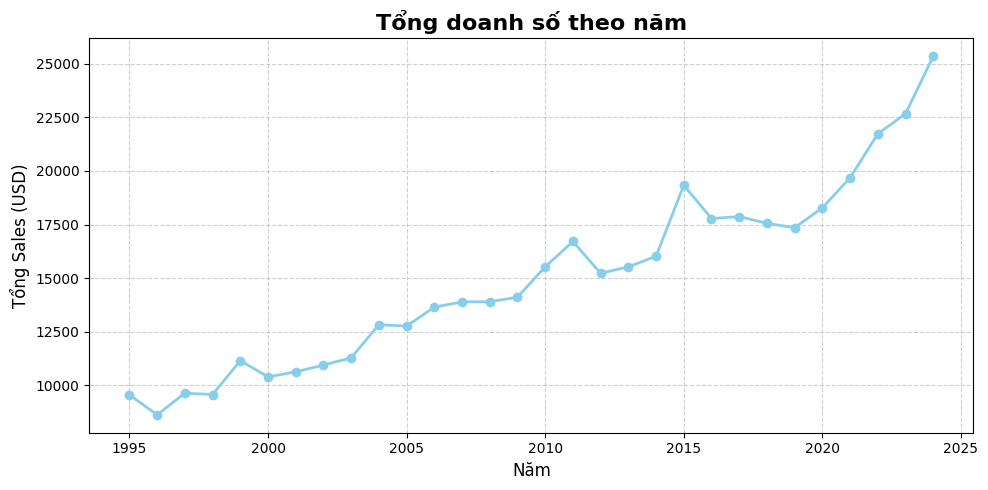

In [82]:
# Tạo dữ liệu
yearly_sales = merged_df.groupby('Year')['New_Sales'].sum()
# Tạo figure
plt.figure(figsize=(10, 5))
plt.plot(yearly_sales.index, yearly_sales.values, marker='o', linestyle='-', color='skyblue', linewidth=2)
plt.title("Tổng doanh số theo năm", fontsize=16, fontweight='bold')
plt.xlabel("Năm", fontsize=12)
plt.ylabel("Tổng Sales (USD)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
# Hiển thị biểu đồ
plt.show()


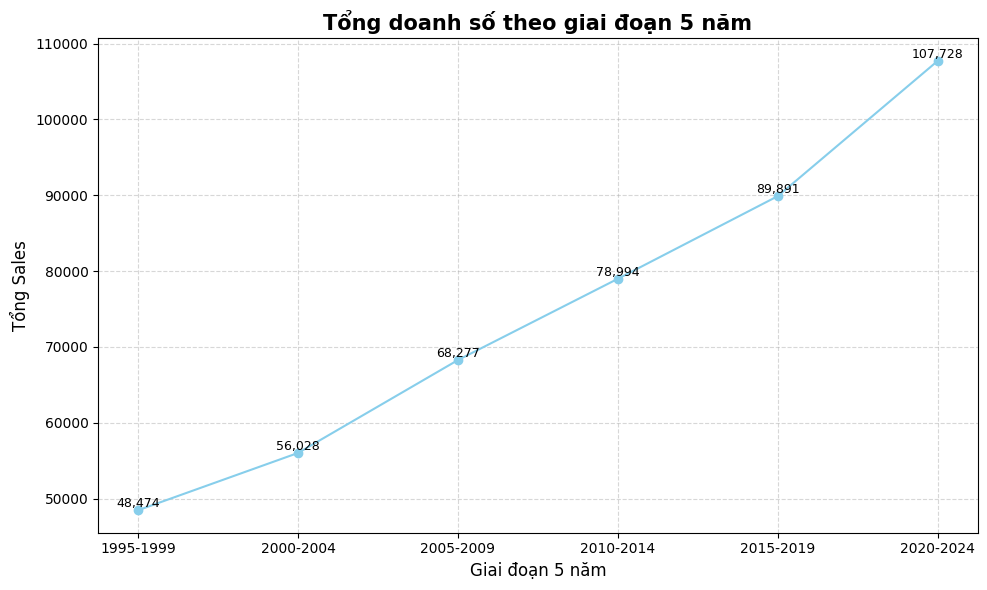

In [83]:
# Bước 1: Tạo nhãn giai đoạn 5 năm
merged_df['Year_Group'] = (merged_df['Year'] // 5) * 5
merged_df['Year_Group_Label'] = merged_df['Year_Group'].astype(str) + '-' + (merged_df['Year_Group'] + 4).astype(str)

# Bước 2: Tính tổng doanh số theo giai đoạn
sales_by_5yrs = merged_df.groupby('Year_Group_Label')['New_Sales'].sum().reset_index()

# Bước 3: Vẽ biểu đồ line
plt.figure(figsize=(10, 6))
plt.plot(sales_by_5yrs['Year_Group_Label'], sales_by_5yrs['New_Sales'], marker='o', linestyle='-', color='skyblue')

# Bước 4: Trang trí
plt.title('Tổng doanh số theo giai đoạn 5 năm', fontsize=15, fontweight='bold')
plt.xlabel('Giai đoạn 5 năm', fontsize=12)
plt.ylabel('Tổng Sales', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Thêm số liệu lên điểm
for x, y in zip(sales_by_5yrs['Year_Group_Label'], sales_by_5yrs['New_Sales']):
    plt.text(x, y, f"{y:,.0f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()



/var/folders/rh/0r4k_tw56sd9fl7wsl3tjh1m0000gn/T/ipykernel_45297/3030221595.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


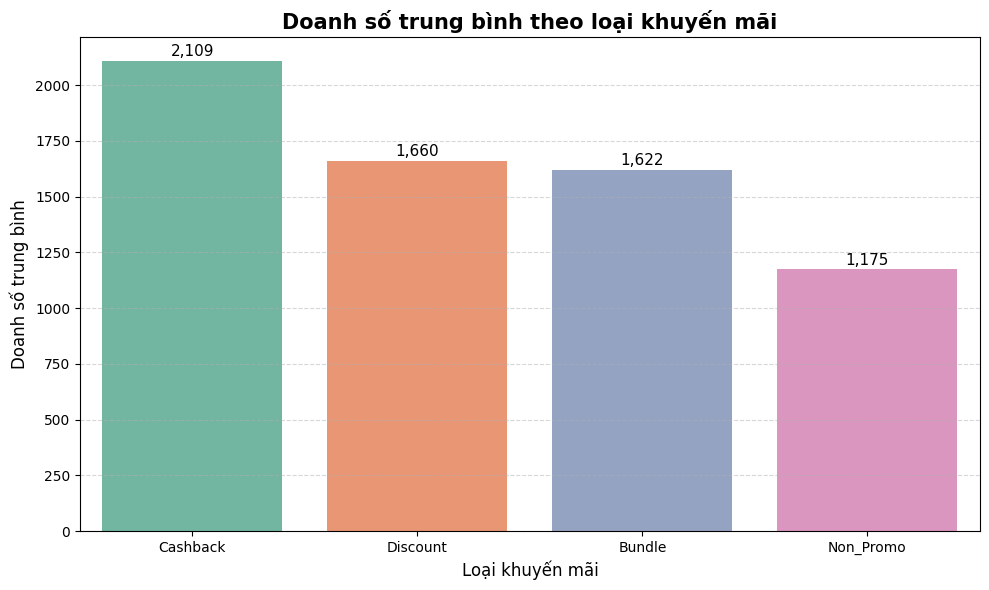

In [84]:

# Tính doanh số trung bình theo loại khuyến mãi
promo_comparison = merged_df.groupby('Promo_Type')['New_Sales'].mean().sort_values(ascending=False).round(2)

# Thiết lập figure và style
plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    x=promo_comparison.index,
    y=promo_comparison.values,
    palette='Set2'
)

# Thêm số trên đầu cột
for i, v in enumerate(promo_comparison.values):
    plt.text(i, v + promo_comparison.max() * 0.01, f"{v:,.0f}", ha='center', fontsize=11)

# Trang trí
plt.title('Doanh số trung bình theo loại khuyến mãi', fontsize=15, fontweight='bold')
plt.xlabel('Loại khuyến mãi', fontsize=12)
plt.ylabel('Doanh số trung bình', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [85]:
# Chia dữ liệu thành 2 nhóm: có và không có khuyến mãi
promo_sales = df[df['Promo_Type'] != 'Non_Promo']['New_Sales']
no_promo_sales = df[df['Promo_Type'] == 'Non_Promo']['New_Sales']

# Thực hiện T-test
t_stat, p_val = ttest_ind(promo_sales, no_promo_sales, equal_var=False)  # Welch’s t-test

# In kết quả
print(" Kết quả T-test giữa tháng có khuyến mãi và không có khuyến mãi:")
print(f"→ Mean (Có khuyến mãi): {promo_sales.mean():.2f}")
print(f"→ Mean (Không có khuyến mãi): {no_promo_sales.mean():.2f}")
print(f"→ T-statistic: {t_stat:.2f}")
print(f"→ P-value: {p_val:.4f}")

# Diễn giải
if p_val < 0.05:
    print("\nCó sự khác biệt có ý nghĩa thống kê: Khuyến mãi ảnh hưởng đến doanh số.")
else:
    print("\nKhông có bằng chứng thống kê rõ ràng cho thấy khuyến mãi làm thay đổi doanh số.")



 Kết quả T-test giữa tháng có khuyến mãi và không có khuyến mãi:
→ Mean (Có khuyến mãi): 1665.13
→ Mean (Không có khuyến mãi): 1174.76
→ T-statistic: 6.39
→ P-value: 0.0000

Có sự khác biệt có ý nghĩa thống kê: Khuyến mãi ảnh hưởng đến doanh số.


In [86]:
print(merged_df.columns)


Index(['New_Sales', 'Year', 'Month', 'YearMonth', 'Promo_ID', 'Active_Month',
       'Promo_Type', 'Budget_USD', 'Year_Group', 'Year_Group_Label'],
      dtype='object')


In [88]:

# Tạo cột Has_Promo nếu chưa có
merged_df['Has_Promo'] = merged_df['Promo_Type'].apply(lambda x: 0 if x == 'Non_Promo' else 1)


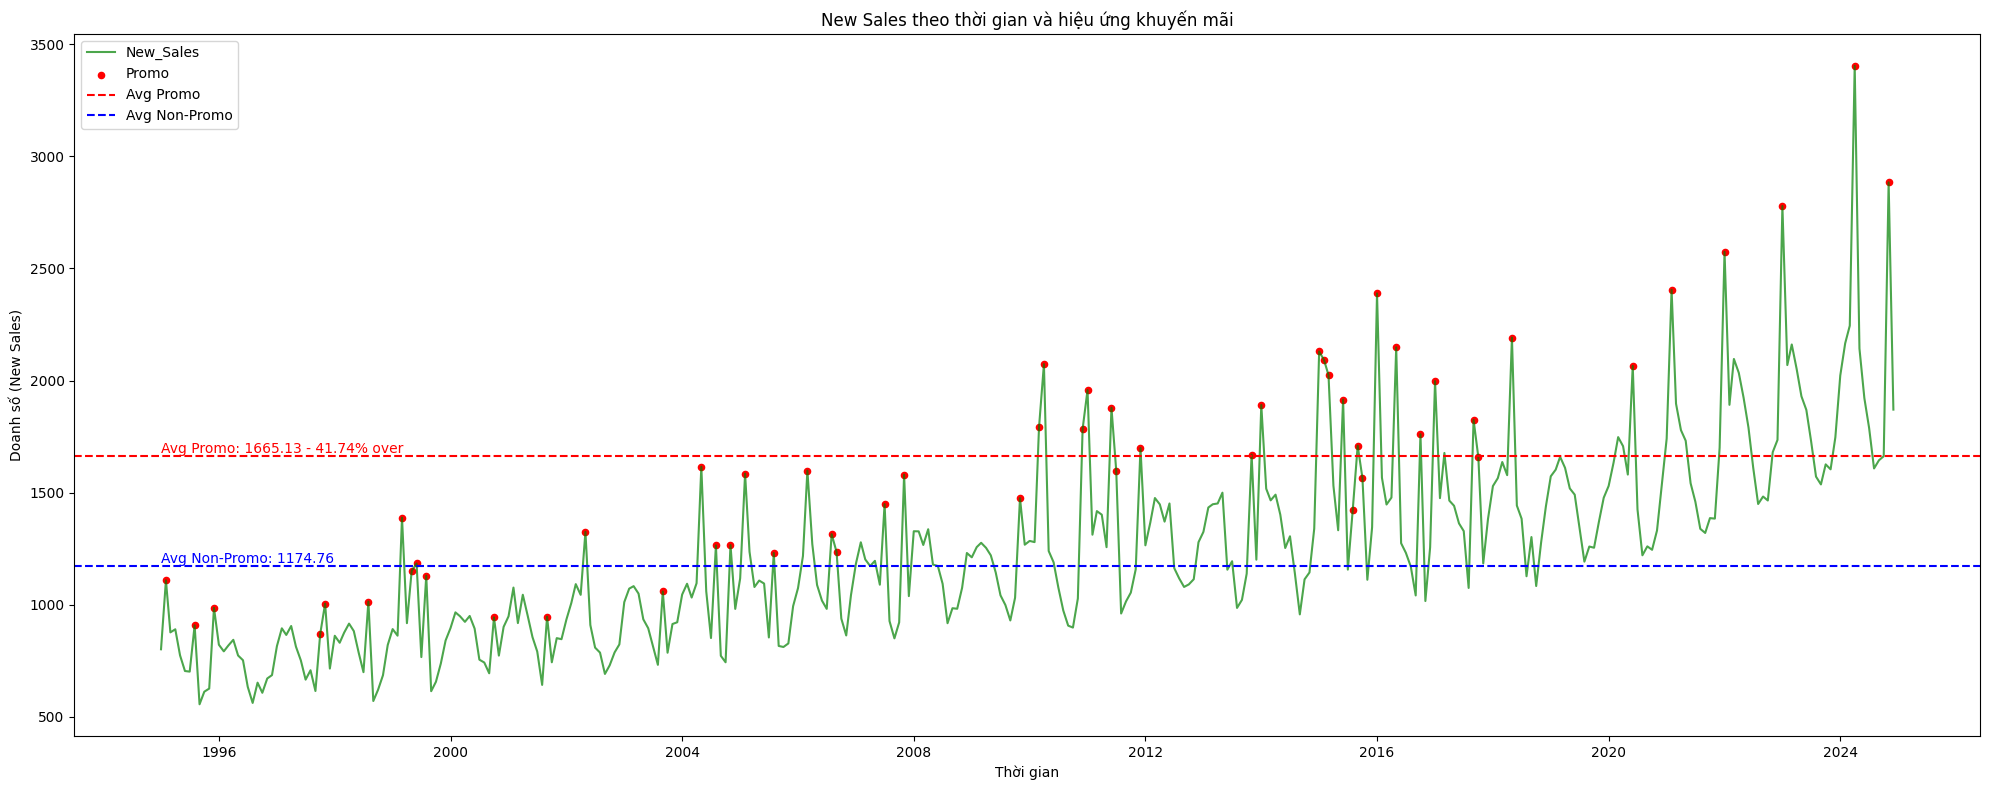

In [89]:
merged_df["Date_ts"] = pd.to_datetime(merged_df["Year"].astype(str) + "-" + merged_df["Month"].astype(str) + "-01")
# Tạo cột thời gian (nếu chưa có)
merged_df["Date_ts"] = pd.to_datetime(merged_df["Year"].astype(str) + "-" + merged_df["Month"].astype(str) + "-01")


fig, ax = plt.subplots(figsize=(20,8))

sns.lineplot(data=merged_df, x="Date_ts", y="New_Sales", ax=ax, color="green", alpha=0.7, label="New_Sales")

# Tách ra các điểm có promo và không
promo = merged_df[merged_df["Has_Promo"] == 1]
nonpromo = merged_df[merged_df["Has_Promo"] == 0]


ax.scatter(
    promo["Date_ts"],
    promo["New_Sales"],
    s=20,
    color="red",
    marker="o",
    label="Promo"
)

# Đường trung bình
avg_sales_promo = promo["New_Sales"].mean()
avg_sales_nonpromo = nonpromo["New_Sales"].mean()

# Vẽ đường trung bình
x_start = merged_df["Date_ts"].min()
ax.axhline(avg_sales_promo, color="red", linestyle="--", label="Avg Promo")
ax.axhline(avg_sales_nonpromo, color="blue", linestyle="--", label="Avg Non-Promo")

ax.text(x_start, avg_sales_promo, 
        f"Avg Promo: {avg_sales_promo:.2f} - {(avg_sales_promo/avg_sales_nonpromo - 1)*100:.2f}% over", 
        ha="left", va="bottom", color="red")

ax.text(x_start, avg_sales_nonpromo, 
        f"Avg Non-Promo: {avg_sales_nonpromo:.2f}", 
        ha="left", va="bottom", color="blue")


ax.legend()
plt.title("New Sales theo thời gian và hiệu ứng khuyến mãi")
plt.xlabel("Thời gian")
plt.ylabel("Doanh số (New Sales)")
plt.tight_layout()
plt.show()


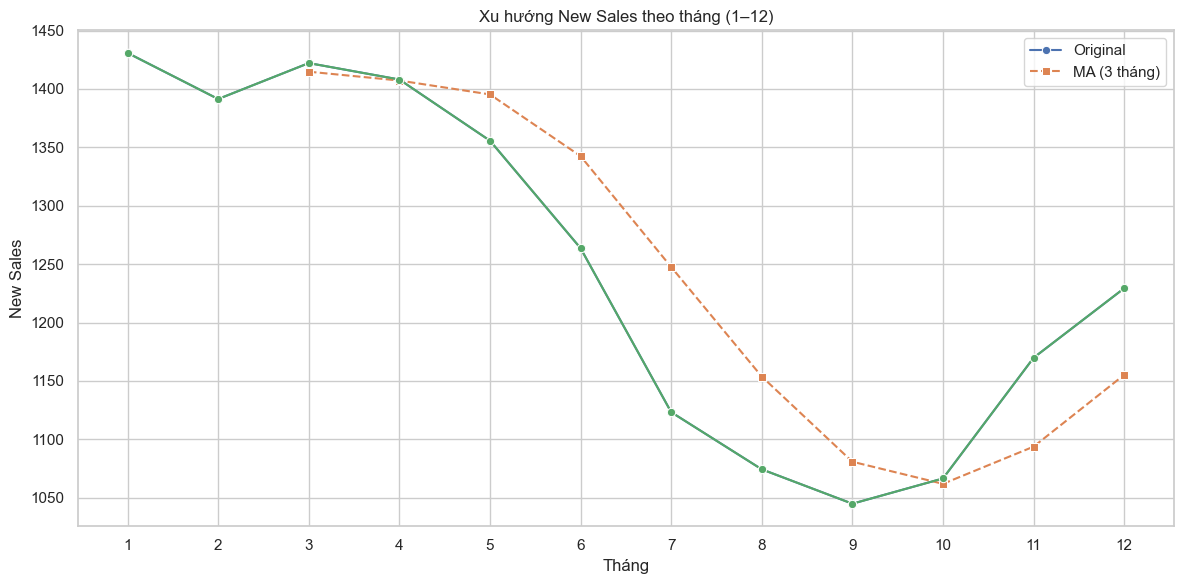

In [ ]:
# Tính doanh số trung bình và chuyển thành DataFrame
monthly_avg = merged_df.groupby('Month')['New_Sales'].mean().reset_index()

# Đổi tên cột cho dễ dùng (không bắt buộc nhưng nên làm)
monthly_avg.columns = ['Tháng', 'New_Sales']
# Tính Moving Average 3 tháng
monthly_avg['MA_3'] = monthly_avg['New_Sales'].rolling(window=3).mean()

# Vẽ line chart với MA
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_avg, x='Tháng', y='New_Sales', label='Original', marker='o')
sns.lineplot(data=monthly_avg, x='Tháng', y='MA_3', label='MA (3 tháng)', marker='s', linestyle='--')

# Vẽ line chart với seaborn
plt.title('Xu hướng New Sales theo tháng (1–12)')
plt.xlabel('Tháng')
plt.ylabel('New Sales')
plt.xticks(ticks=range(1, 13), labels=[str(m) for m in range(1, 13)])
plt.grid(True)
plt.legend()
plt.tight_layout()
sns.lineplot(data=monthly_avg, x='Tháng', y='New_Sales', marker='o')
plt.show()


In [ ]:

# Bước 1: Gán mùa
season_mapping = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
}
merged_df['Season'] = merged_df['Month'].map(season_mapping)

# Bước 2: Tính tổng doanh số theo mùa
seasonal_sales = merged_df.groupby('Season')['New_Sales'].mean().reset_index()
seasonal_sales


,Season,New_Sales
0,Fall,1093.679638
1,Spring,1395.335000
2,Summer,1153.710451
3,Winter,1350.527950


In [ ]:
seasonal_sales = merged_df.groupby('Season')['Budget_USD'].mean().reset_index()
seasonal_sales

,Season,Budget_USD
0,Fall,2511.111111
1,Spring,1744.444444
2,Summer,2300.000000
3,Winter,2122.222222


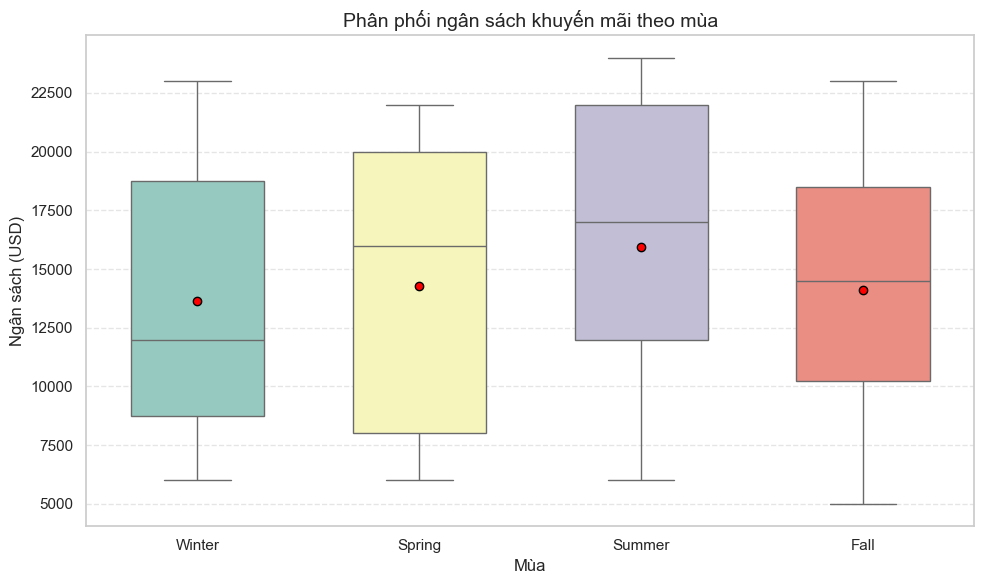

In [ ]:
promo_df = merged_df[merged_df['Promo_Type'] != 'Non_Promo'].copy()
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
promo_df['Season'] = pd.Categorical(promo_df['Season'], categories=season_order, ordered=True)

# Tạo boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=promo_df,
    x='Season',
    y='Budget_USD',
    palette='Set3',
    width=0.6,
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "black"}
)

# Trang trí
plt.title('Phân phối ngân sách khuyến mãi theo mùa', fontsize=14)
plt.xlabel('Mùa')
plt.ylabel('Ngân sách (USD)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

1. Mùa hè (Summer):
Có median (trung vị) ngân sách cao nhất trong các mùa.

Khoảng phân vị (IQR) rộng, cho thấy sự dao động lớn trong mức chi ngân sách.

Có nhiều ngân sách vượt trội (quai whisker phía trên dài).

Mean (dấu chấm đỏ) cũng cao hơn median, cho thấy có thể có một vài điểm ngân sách rất cao kéo trung bình lên → phân phối bị lệch phải (right-skewed).

2. Mùa xuân (Spring):
Mức median cao thứ 2, khá gần với Summer.

Phân phối khá ổn định, IQR không quá rộng.

Mean hơi cao hơn median, có thể vẫn có một vài ngân sách cao nhưng không cực đoan.

3. Mùa thu (Fall):
Median và mean gần nhau, phân phối cân bằng.

Nhưng IQR lớn, nghĩa là có các chiến dịch khuyến mãi rất khác nhau về ngân sách trong cùng mùa này.

Có một vài điểm thấp rõ rệt → có khả năng xuất hiện promo ngân sách thấp vào cuối năm.

4. Mùa đông (Winter):
Median thấp nhất trong cả 4 mùa.

Tuy nhiên, whiskers kéo dài cho thấy vẫn có những tháng ngân sách cao → sự phân tán cao.

Mean lớn hơn median, cũng gợi ý về phân phối lệch phải, nhưng không nhiều bằng Summer.

Tổng kết Insight:
Summer là mùa được đầu tư ngân sách promo cao nhất, nhưng cũng dao động mạnh nhất 

Winter tuy có một số chiến dịch ngân sách cao nhưng đa phần là ngân sách thấp 

Spring và Fall có phân phối ngân sách khá cân bằng, phù hợp với các chiến dịch thường kỳ hoặc dịp chuyển mùa.

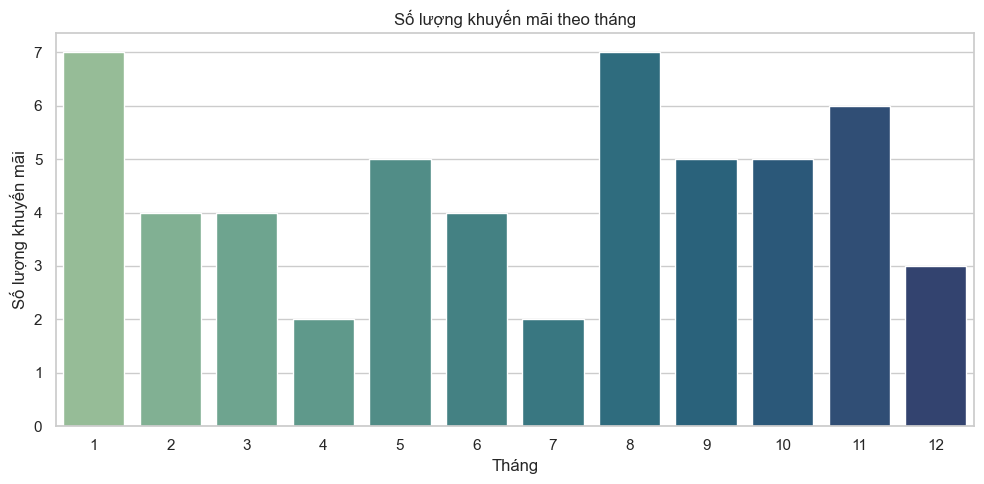

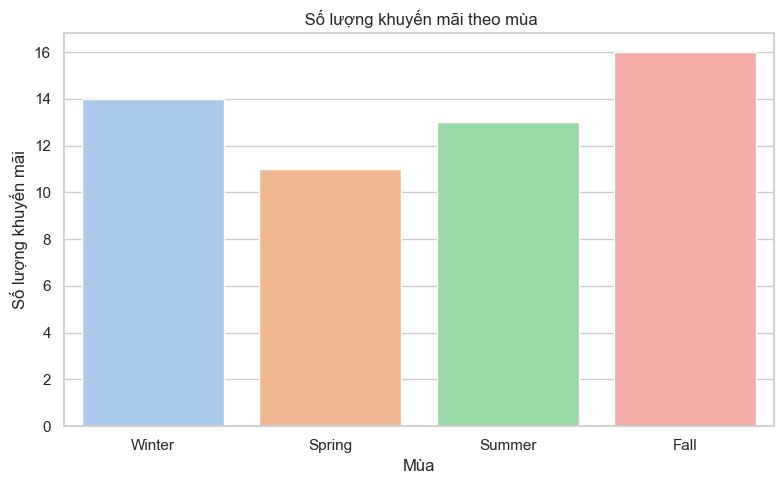

In [ ]:

# Chỉ lấy các dòng có khuyến mãi
promo_only = merged_df[merged_df['Promo_Type'] != 'Non_Promo'].copy()

# Tạo cột Season nếu chưa có
if 'Season' not in promo_only.columns:
    season_mapping = {
        12: 'Winter', 1: 'Winter', 2: 'Winter',
        3: 'Spring', 4: 'Spring', 5: 'Spring',
        6: 'Summer', 7: 'Summer', 8: 'Summer',
        9: 'Fall', 10: 'Fall', 11: 'Fall'
    }
    promo_only['Season'] = promo_only['Month'].map(season_mapping)

# Thiết lập kiểu vẽ đẹp
sns.set(style="whitegrid")

# ======= 1. Count khuyến mãi theo tháng =======
plt.figure(figsize=(10, 5))
sns.countplot(data=promo_only, x='Month', palette='crest')
plt.title('Số lượng khuyến mãi theo tháng')
plt.xlabel('Tháng')
plt.ylabel('Số lượng khuyến mãi')
plt.tight_layout()
plt.show()

# ======= 2. Count khuyến mãi theo mùa =======
plt.figure(figsize=(8, 5))
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
sns.countplot(data=promo_only, x='Season', order=season_order, palette='pastel')
plt.title(' Số lượng khuyến mãi theo mùa')
plt.xlabel('Mùa')
plt.ylabel('Số lượng khuyến mãi')
plt.tight_layout()
plt.show()


Tháng 1 & 8 có nhiều khuyến mãi nhất, Tháng 4 & 7 rất ít 

Fall là mùa có nhiều hoạt động nhất → có thể là mùa cao điểm bán hàng hoặc xả hàng.

Spring ít khuyến mãi nhất

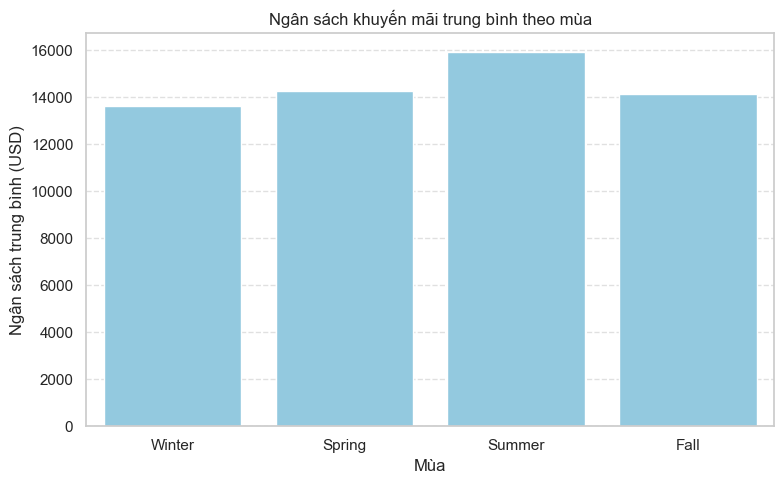

In [ ]:
# Tính ngân sách trung bình theo mùa
seasonal_budget = promo_only.groupby('Season')['Budget_USD'].mean().reset_index()

# Đảm bảo đúng thứ tự mùa
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
seasonal_budget['Season'] = pd.Categorical(seasonal_budget['Season'], categories=season_order, ordered=True)
seasonal_budget = seasonal_budget.sort_values('Season')

# Vẽ biểu đồ cột
plt.figure(figsize=(8, 5))
sns.barplot(data=seasonal_budget, x='Season', y='Budget_USD', color='skyblue')
plt.title('Ngân sách khuyến mãi trung bình theo mùa')
plt.xlabel('Mùa')
plt.ylabel('Ngân sách trung bình (USD)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

| Mùa                  | Số lượng khuyến mãi   | Ngân sách trung bình/lần | Độ ổn định ngân sách     |
| -------------------- | --------------------- | ------------------------ | ------------------------ |
| **Winter (Dec–Feb)** | Cao (14 lần)          | Thấp nhất (\~13.5K USD)  | Dao động rộng            |
| **Spring (Mar–May)** | Thấp nhất (11 lần)    | Vừa (\~14.2K)            | Phân phối không quá rộng |
| **Summer (Jun–Aug)** | Trung bình (13 lần)   | **Cao nhất (\~16K USD)** | Dao động mạnh            |
| **Fall (Sep–Nov)**   | **Cao nhất (16 lần)** | Vừa (\~14K)              | Ổn định hơn              |


**Diễn giải có tính mùa vụ (dựa trên thời tiết và thói quen mua sắm của người Mỹ)**

❄️ Winter – Mùa đang mặc sweater
Khuyến mãi vẫn được đẩy mạnh (14 lần), nhưng mức ngân sách trung bình lại thấp → có thể là các đợt xả kho sau Giáng sinh hoặc kéo dài sức mua dịp sale cuối năm.

Dao động mạnh về ngân sách → cho thấy chiến dịch “xả hàng” hoặc "test thị trường" linh hoạt.

🌱 Spring – Sweater thoát khỏi mùa cao điểm
Số lượng ít nhất, hợp lý vì mùa xuân khách hàng đã giảm nhu cầu với áo ấm.

Doanh nghiệp chỉ còn chạy các promo nhẹ, chủ yếu xử lý tồn kho.

☀️ Summer – Mùa không phù hợp, nhưng ngân sách cao
Dù không phải mùa mặc sweater, nhưng ngân sách mỗi đợt khuyến mãi lại cao nhất.

Có thể là chiến lược off-season clearance mạnh tay (giảm sâu) hoặc build awareness sớm cho mùa thu (Back-to-school, early fall collection).

🍂 Fall – Mùa “bắt đầu” bán sweater
Số lượng khuyến mãi cao nhất (16) cho thấy đây là mùa chiến lược ra mắt bộ sưu tập mới.

Mức chi trung bình không cao nhất, nhưng ổn định và đều → có thể là loạt chiến dịch kéo dài, chuẩn bị trước mùa đông.

| Giai đoạn            | Chiến lược đề xuất                                                                                                                   |
| -------------------- | ------------------------------------------------------------------------------------------------------------------------------------ |
| **Fall (Sep–Nov)**   | Tập trung nhiều khuyến mãi vừa phải để **kích cầu sớm**, đẩy hàng vào đầu mùa lạnh.                                                  |
| **Winter (Dec–Feb)** | Duy trì một số khuyến mãi **mức nhẹ hoặc xả kho** sau lễ, tránh lãng phí ngân sách.                                                  |
| **Spring (Mar–May)** | **Giảm bớt khuyến mãi**, chỉ nên xử lý hàng tồn. Có thể thử bán chéo với sản phẩm xuân hè.                                           |
| **Summer (Jun–Aug)** | Nếu tiếp tục khuyến mãi, nên tập trung vào **chiến dịch off-season clearance lớn**, hoặc build anticipation cho fall collection mới. |


Chiến dịch khuyến mãi sweater nên tập trung dồn lực vào Fall để chuẩn bị thị trường, nhẹ tay vào Winter để tối ưu biên lợi nhuận, và dùng Summer làm thời điểm xả hàng hoặc quảng bá thương hiệu.

Spring bán sweater tốt nhất, dù có ít khuyến mãi nhất → Có thể tận dụng cho chiến dịch outlet/clearance đầu xuân hoặc bán chéo với sản phẩm trung tính (sweater nhẹ, cardigan).

Winter vẫn duy trì tốt, không bất ngờ → Nhưng nên ưu tiên biên lợi nhuận hơn khuyến mãi.

Summer surprisingly khá ổn, nên tận dụng bán off-season kết hợp quảng bá.

Fall không hiệu quả về doanh số sweater dù nhiều khuyến mãi:

Cần đánh giá lại content/targeting của promo Fall: có thực sự push sweater hay không?

Hoặc chuyển hướng sang build brand/awareness thay vì kỳ vọng doanh số.

## **Multi**

In [ ]:

# Bước 1: Loại bỏ các dòng không có khuyến mãi
promo_only = merged_df[merged_df['Promo_Type'] != 'Non_Promo'].copy()
# Bước 2: Tổng hợp theo mùa và loại khuyến mãi
summary = promo_only.groupby(['Season', 'Promo_Type']).agg({
    'New_Sales': 'sum',
    'Budget_USD': 'sum',
    'Promo_ID': 'count'  # dùng Promo_ID để đếm số chiến dịch
}).rename(columns={
    'New_Sales': 'Total_Sales',
    'Budget_USD': 'Total_Budget',
    'Promo_ID': 'Campaign_Count'
}).reset_index()
# Bước 4: Sắp xếp thứ tự mùa
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
summary['Season'] = pd.Categorical(summary['Season'], categories=season_order, ordered=True)
summary = summary.sort_values(['Season', 'Promo_Type'])

# Bước 5: Hiển thị bảng đẹp
print("Tổng hợp theo Mùa và Loại Khuyến Mãi:\n")
print(tabulate(
    summary,
    headers='keys',
    tablefmt='fancy_grid',
    showindex=False,
    floatfmt=(".0f", ".0f", ".0f", ".0f", ".1f")
))


Tổng hợp theo Mùa và Loại Khuyến Mãi:

╒══════════╤══════════════╤═══════════════╤════════════════╤══════════════════╕
│ Season   │ Promo_Type   │   Total_Sales │   Total_Budget │   Campaign_Count │
╞══════════╪══════════════╪═══════════════╪════════════════╪══════════════════╡
│ Winter   │ Bundle       │         18131 │         126000 │                9 │
├──────────┼──────────────┼───────────────┼────────────────┼──────────────────┤
│ Winter   │ Discount     │          9246 │          65000 │                5 │
├──────────┼──────────────┼───────────────┼────────────────┼──────────────────┤
│ Spring   │ Bundle       │         10695 │          90000 │                6 │
├──────────┼──────────────┼───────────────┼────────────────┼──────────────────┤
│ Spring   │ Cashback     │          6328 │          33000 │                3 │
├──────────┼──────────────┼───────────────┼────────────────┼──────────────────┤
│ Spring   │ Discount     │          3689 │          34000 │                2 │
├

In [ ]:
# Tạo Season nếu chưa có
def assign_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

merged_df['Season'] = merged_df['Month'].apply(assign_season)

import pandas as pd

# Lọc các dòng có khuyến mãi (loại trừ 'Non_Promo')
promo_df = merged_df[merged_df['Promo_Type'] != 'Non_Promo'].copy()

# Đảm bảo thứ tự các mùa
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
promo_df['Season'] = pd.Categorical(promo_df['Season'], categories=season_order, ordered=True)

# Tính ngân sách trung bình theo mùa và loại khuyến mãi
avg_budget_by_season_type = (
    promo_df.groupby(['Season', 'Promo_Type'])['Budget_USD']
    .mean()
    .reset_index()
    .sort_values(by=['Season', 'Promo_Type'])
)

# In kết quả
print(avg_budget_by_season_type)


    Season Promo_Type    Budget_USD
0   Winter     Bundle  14000.000000
1   Winter   Cashback           NaN
2   Winter   Discount  13000.000000
3   Spring     Bundle  15000.000000
4   Spring   Cashback  11000.000000
5   Spring   Discount  17000.000000
6   Summer     Bundle  18500.000000
7   Summer   Cashback           NaN
8   Summer   Discount  14777.777778
9     Fall     Bundle  14444.444444
10    Fall   Cashback           NaN
11    Fall   Discount  13714.285714


In [ ]:
# Tính Pearson correlation
x = merged_df['Budget_USD']
y = merged_df['New_Sales']
corr, p_value = pearsonr(x, y)

print("Pearson Correlation between Budget and New Sales:")
print("r =", round(corr, 3))
print("p-value =", round(p_value, 4))


Pearson Correlation between Budget and New Sales:
r = 0.422
p-value = 0.0


Ngân sách khuyến mãi có ảnh hưởng đến doanh số sweater ở mức trung bình, đáng tin cậy về mặt thống kê

Pearson Correlation giữa Budget và Sales theo từng loại khuyến mãi:
→ Bundle: r = 0.16, p = 0.423
→ Discount: r = 0.28, p = 0.190
→ Cashback: r = 0.97, p = 0.168
Correlation CHUNG giữa Budget và Sales:
→ Pearson r = 0.24, p-value = 0.0829


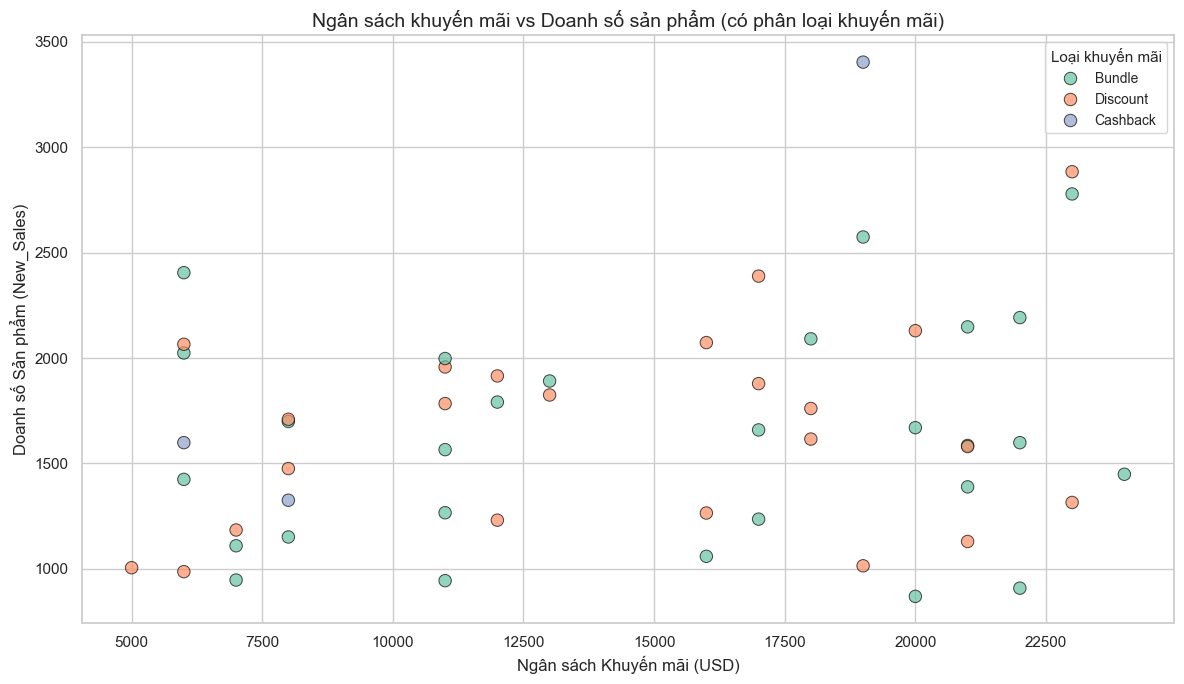

In [ ]:
# Bước 1: Lọc ra các dòng có khuyến mãi
promo_only = merged_df[merged_df['Promo_Type'] != 'Non_Promo'].copy()

# Bước 2: Thiết lập plot
plt.figure(figsize=(12, 7))
sns.set(style='whitegrid', palette='Set2')

# Bước 3: Vẽ scatter plot
sns.scatterplot(
    data=promo_only,
    x='Budget_USD',
    y='New_Sales',
    hue='Promo_Type',
    alpha=0.7,
    edgecolor='black',
    s=80
)

# Bước 4: Thêm thông tin tương quan cho từng loại promo
print("Pearson Correlation giữa Budget và Sales theo từng loại khuyến mãi:")
for promo in promo_only['Promo_Type'].unique():
    df_sub = promo_only[promo_only['Promo_Type'] == promo]
    if len(df_sub) >= 2:
        r, p = pearsonr(df_sub['Budget_USD'], df_sub['New_Sales'])
        print(f"→ {promo}: r = {r:.2f}, p = {p:.3f}")
    else:
        print(f"→ {promo}: Không đủ dữ liệu")

# Loại bỏ NaN nếu có
df_corr = promo_only.dropna(subset=['Budget_USD', 'New_Sales'])

# Tính Pearson Correlation
r_all, p_all = pearsonr(df_corr['Budget_USD'], df_corr['New_Sales'])

print(f"Correlation CHUNG giữa Budget và Sales:")
print(f"→ Pearson r = {r_all:.2f}, p-value = {p_all:.4f}")

# Bước 5: Giao diện đồ họa
plt.title("Ngân sách khuyến mãi vs Doanh số sản phẩm (có phân loại khuyến mãi)", fontsize=14)
plt.xlabel("Ngân sách Khuyến mãi (USD)", fontsize=12)
plt.ylabel("Doanh số Sản phẩm (New_Sales)", fontsize=12)
plt.legend(title="Loại khuyến mãi", title_fontsize=11, fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


 Không có loại khuyến mãi nào cho thấy mối tương quan rõ ràng và đáng tin cậy giữa ngân sách và doanh số sweater.


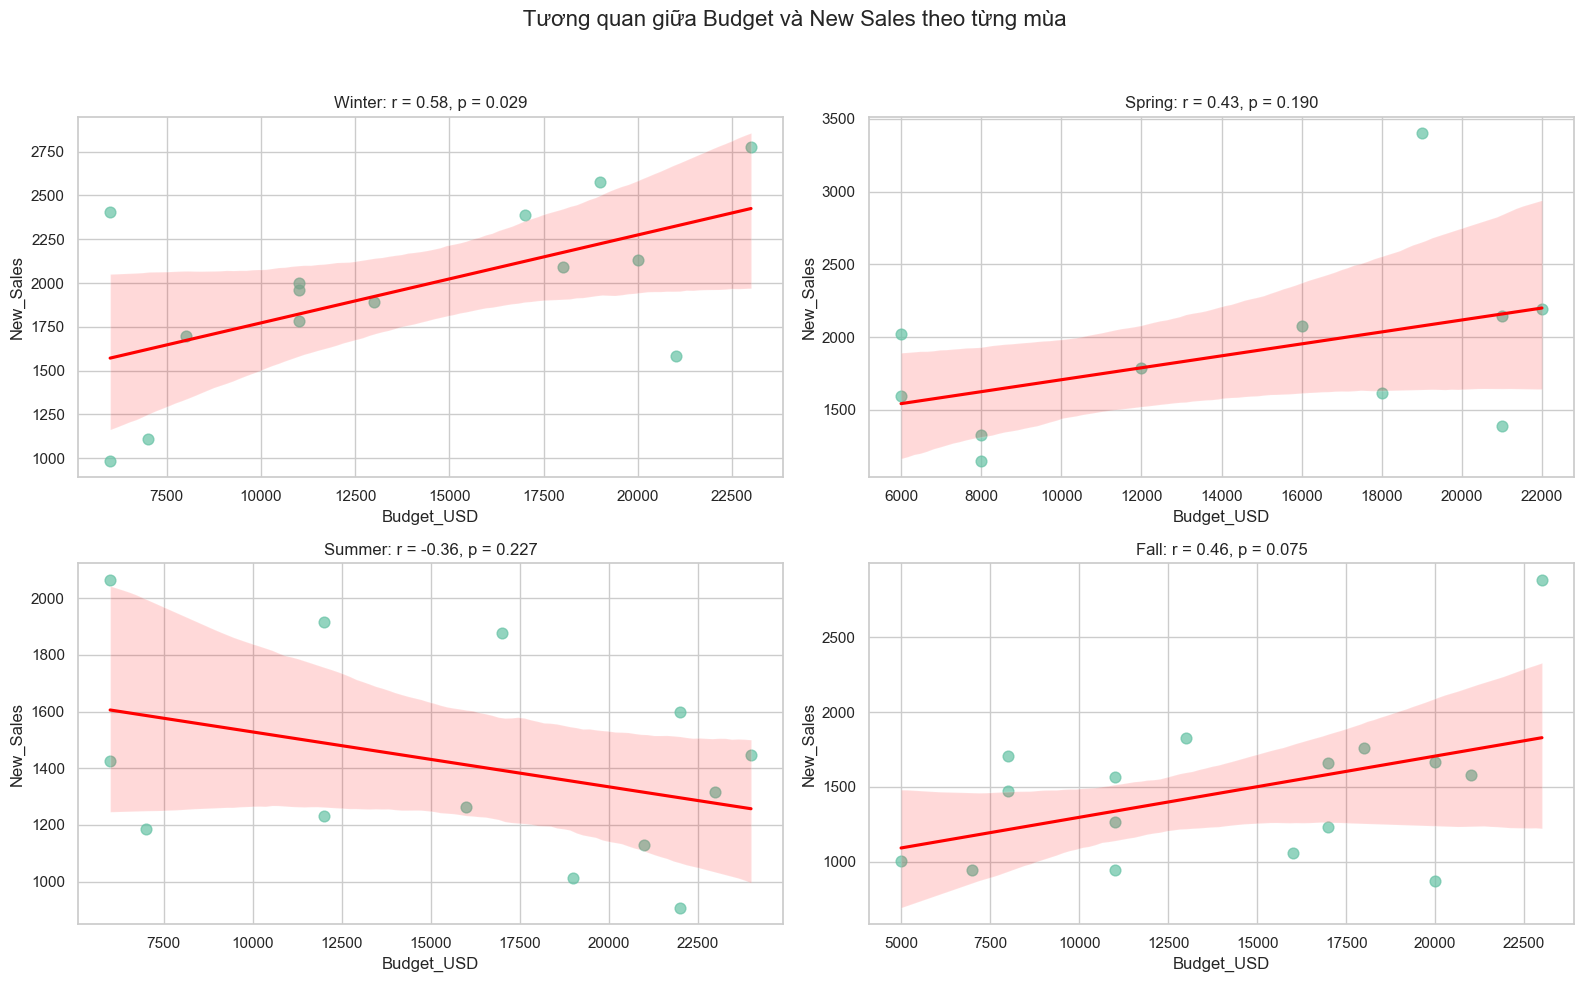

In [ ]:
# Lọc những tháng có khuyến mãi
promo_only = merged_df[merged_df['Promo_Type'] != 'Non_Promo'].copy()
promo_only = promo_only.dropna(subset=['Budget_USD', 'New_Sales', 'Season'])

# Lấy danh sách mùa theo thứ tự
seasons = ['Winter', 'Spring', 'Summer', 'Fall']

# Tạo figure nhiều biểu đồ
plt.figure(figsize=(16, 10))
for i, season in enumerate(seasons, 1):
    subset = promo_only[promo_only['Season'] == season]

    if len(subset) >= 2:  # cần ít nhất 2 điểm để tính tương quan
        r, p = pearsonr(subset['Budget_USD'], subset['New_Sales'])
        title = f"{season}: r = {r:.2f}, p = {p:.3f}"
    else:
        title = f"{season}: Không đủ dữ liệu"

    plt.subplot(2, 2, i)
    sns.regplot(
        data=subset,
        x='Budget_USD',
        y='New_Sales',
        scatter_kws={'s': 60, 'alpha': 0.7},
        line_kws={'color': 'red'}
    )
    plt.title(title)
    plt.xlabel('Budget_USD')
    plt.ylabel('New_Sales')
    plt.grid(True)

plt.suptitle(' Tương quan giữa Budget và New Sales theo từng mùa', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Chi tiền khuyến mãi mùa hè có thể phản tác dụng, vì nhu cầu sweater thấp → chi nhiều không kéo được doanh số

Mùa thu có thể bắt đầu có hiệu quả khi chi ngân sách, vì đây là giai đoạn nhu cầu sweater bắt đầu tăng

Khi tăng ngân sách khuyến mãi vào mùa đông, doanh số sweater có xu hướng tăng rõ ràng

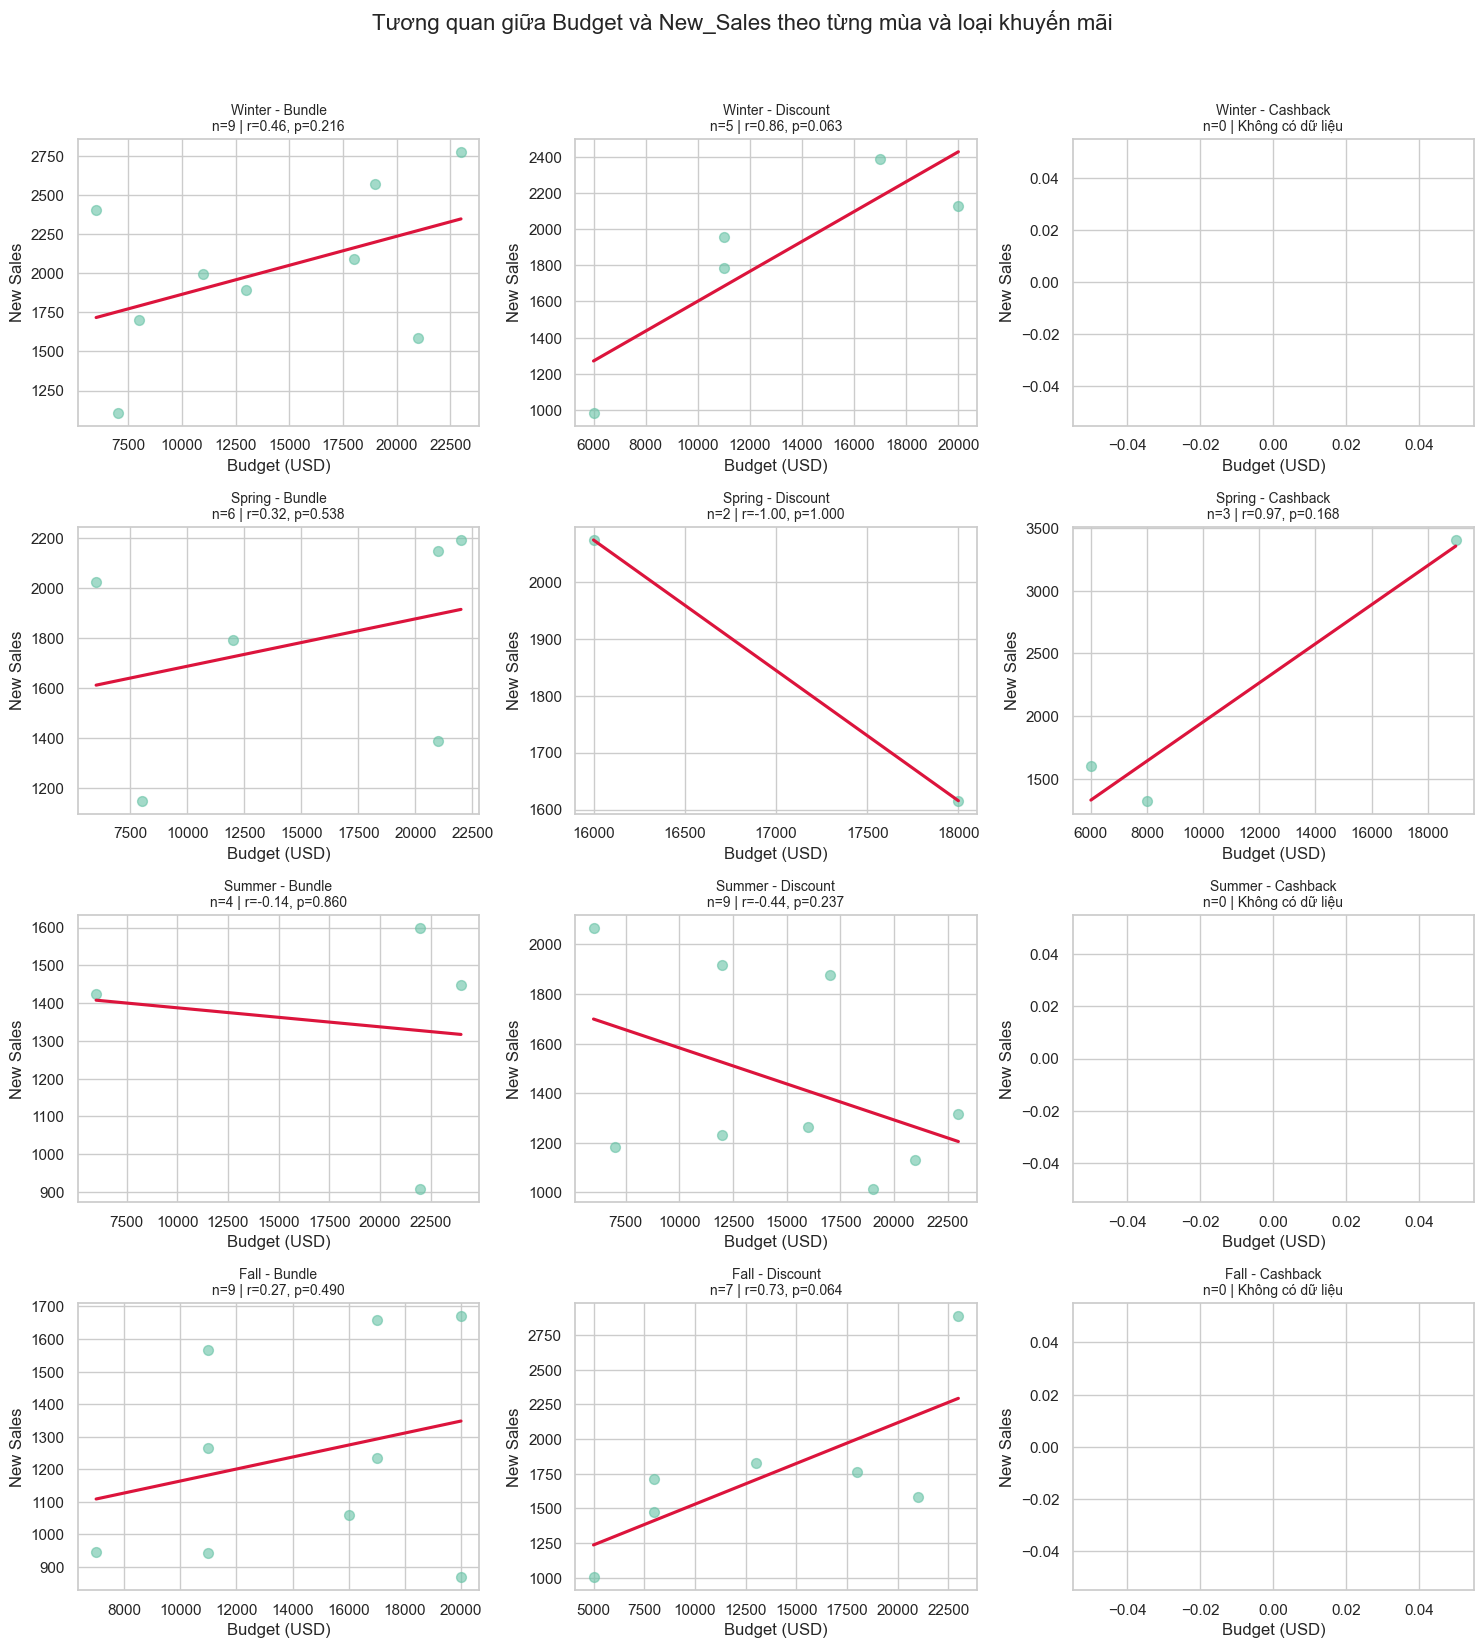

In [ ]:


def plot_correlation_by_season_and_promo(df, budget_col='Budget_USD', sales_col='New_Sales'):
    # Lọc các dòng có promo thật
    df = df[df['Promo_Type'] != 'Non_Promo'].copy()
    df = df.dropna(subset=[budget_col, sales_col, 'Season'])

    # Danh sách mùa và loại promo
    seasons = ['Winter', 'Spring', 'Summer', 'Fall']
    promo_types = df['Promo_Type'].unique()
    num_cols = len(promo_types)
    num_rows = len(seasons)

    plt.figure(figsize=(5 * num_cols, 4.2 * num_rows))

    plot_index = 1
    for i, season in enumerate(seasons):
        for j, promo in enumerate(promo_types):
            subset = df[(df['Season'] == season) & (df['Promo_Type'] == promo)]

            plt.subplot(num_rows, num_cols, plot_index)

            if len(subset) >= 2:
                r, p = pearsonr(subset[budget_col], subset[sales_col])
                title = f"{season} - {promo}\nn={len(subset)} | r={r:.2f}, p={p:.3f}"
            elif len(subset) == 1:
                title = f"{season} - {promo}\nn=1 | Không đủ dữ liệu"
            else:
                title = f"{season} - {promo}\nn=0 | Không có dữ liệu"

            sns.regplot(
                data=subset,
                x=budget_col,
                y=sales_col,
                scatter_kws={'s': 50, 'alpha': 0.6},
                line_kws={'color': 'crimson'},
                ci=None
            )
            plt.title(title, fontsize=10)
            plt.xlabel("Budget (USD)")
            plt.ylabel("New Sales")
            plt.grid(True)

            plot_index += 1

    plt.suptitle("Tương quan giữa Budget và New_Sales theo từng mùa và loại khuyến mãi", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Gọi hàm:
plot_correlation_by_season_and_promo(merged_df)


📌 1. Winter (Mùa Đông)
Bundle:

r = 0.46, p = 0.216, mối tương quan dương nhẹ, nhưng không có ý nghĩa thống kê.

→ Ngân sách tăng có thể giúp tăng doanh số, nhưng chưa rõ ràng.

Discount:

r = 0.86, p = 0.063, mối tương quan dương rất mạnh, gần đạt mức ý nghĩa thống kê.

→ Khuyến mãi dạng giảm giá vào mùa đông rất hiệu quả, đặc biệt khi ngân sách cao.

Cashback:

Không có dữ liệu.

📌 2. Spring (Mùa Xuân)
Bundle:

r = 0.32, p = 0.538, tương quan yếu và không đáng kể.

Discount:

r = 1.00, p = 1.000, có vẻ chỉ có 2 điểm dữ liệu nên không đáng tin cậy.

Cashback:

r = 0.97, p = 0.168, tương quan rất mạnh nhưng dữ liệu còn hạn chế.

📌 3. Summer (Mùa Hè)
Bundle:

r = -0.14, p = 0.860, gần như không có tương quan.

Discount:

r = -0.44, p = 0.237, có xu hướng ngược chiều (ngân sách cao → sales thấp), nhưng chưa đáng kể.

Cashback:

Không có dữ liệu.

📌 4. Fall (Mùa Thu)
Bundle:

r = 0.27, p = 0.490, tương quan nhẹ và không đáng kể.

Discount:

r = 0.73, p = 0.064, tương quan mạnh, gần đạt mức ý nghĩa thống kê.

→ Giống như mùa đông, discount trong mùa thu hoạt động khá tốt khi được đầu tư ngân sách cao.

Cashback:

Không có dữ liệu.

=> đầu tư discount vào thu đông

In [ ]:

# === STEP 1: Tiền xử lý ===
df = merged_df.copy()
df = df.sort_values(by=['Year', 'Month']).reset_index(drop=True)

# Doanh số trung bình toàn dataset
overall_mean_sales = df['New_Sales'].mean()

# Tạo các cột t-1
df['Sales_t-1'] = df['New_Sales'].shift(1)
df['Promo_t'] = df['Promo_Type']
df['Promo_t-1'] = df['Promo_Type'].shift(1)

# === STEP 2: Phân tích riêng Cashback ===
cashback_df = df[df['Promo_t'] == 'Cashback'].copy()
cashback_df['Was_Weak_Before'] = cashback_df['Sales_t-1'] < overall_mean_sales
cashback_df['Sales_Improved'] = cashback_df['New_Sales'] > cashback_df['Sales_t-1']

# Tổng hợp kết quả
total_cashbacks = len(cashback_df)
weak_before = cashback_df['Was_Weak_Before'].sum()
improved = cashback_df['Sales_Improved'].sum()
both_conditions = ((cashback_df['Was_Weak_Before']) & (cashback_df['Sales_Improved'])).sum()

print("🔍 PHÂN TÍCH CASHBACK:")
print(f"Tổng lần xuất hiện Cashback: {total_cashbacks}")
print(f"Trước đó có dấu hiệu 'ế' (< trung bình): {weak_before} ({weak_before/total_cashbacks:.0%})")
print(f"Doanh số tăng sau Cashback: {improved} ({improved/total_cashbacks:.0%})")
print(f"Cả 2 điều kiện đúng: {both_conditions} ({both_conditions/total_cashbacks:.0%})")

cashback_detail = cashback_df[['Year', 'Month', 'Sales_t-1', 'New_Sales', 'Was_Weak_Before', 'Sales_Improved']]

# === STEP 3: So sánh % tăng doanh số với các khuyến mãi khác ===
df_promo = df[df['Promo_t'] != 'Non_Promo'].dropna(subset=['Sales_t-1'])
df_promo['Sales_Growth_%'] = ((df_promo['New_Sales'] - df_promo['Sales_t-1']) / df_promo['Sales_t-1']) * 100

# Tính trung bình theo loại
growth_summary = df_promo.groupby('Promo_t')['Sales_Growth_%'].agg(['mean', 'std', 'count']).round(2)
print("\nTrung bình % tăng doanh số theo loại khuyến mãi:")
print(growth_summary)

# So sánh thống kê giữa Cashback và các loại khác
cashback_growth = df_promo[df_promo['Promo_t'] == 'Cashback']['Sales_Growth_%']
discount_growth = df_promo[df_promo['Promo_t'] == 'Discount']['Sales_Growth_%']
bundle_growth = df_promo[df_promo['Promo_t'] == 'Bundle']['Sales_Growth_%']

print("\n So sánh Cashback vs Discount:")
t_stat1, p_val1 = ttest_ind(cashback_growth, discount_growth, equal_var=False)
print(f"  ➤ t = {t_stat1:.2f}, p = {p_val1:.4f}")

print("\nSo sánh Cashback vs Bundle:")
t_stat2, p_val2 = ttest_ind(cashback_growth, bundle_growth, equal_var=False)
print(f"  ➤ t = {t_stat2:.2f}, p = {p_val2:.4f}")

# Hiển thị bảng chi tiết nếu cần
from IPython.display import display
display(cashback_detail)


🔍 PHÂN TÍCH CASHBACK:
Tổng lần xuất hiện Cashback: 3
Trước đó có dấu hiệu 'ế' (< trung bình): 2 (67%)
Doanh số tăng sau Cashback: 3 (100%)
Cả 2 điều kiện đúng: 2 (67%)

Trung bình % tăng doanh số theo loại khuyến mãi:
           mean    std  count
Promo_t                      
Bundle    33.30  24.12     28
Cashback  36.63  13.19      3
Discount  45.62  22.02     23

 So sánh Cashback vs Discount:
  ➤ t = -1.01, p = 0.3742

So sánh Cashback vs Bundle:
  ➤ t = 0.37, p = 0.7285


,Year,Month,Sales_t-1,New_Sales,Was_Weak_Before,Sales_Improved
88,2002,5,1044.024096,1325.174995,True,True
134,2006,3,1217.294512,1598.479152,True,True
351,2024,4,2244.864957,3404.428595,False,True


 Kết luận sơ bộ: Có dấu hiệu ủng hộ giả thuyết rằng Cashback được sử dụng như một biện pháp "giải cứu" khi doanh số yếu, và có hiệu quả trong việc kéo doanh số lên.

 Cashback không có mức tăng cao nhất về trung bình (thua Discount).

Std thấp nhất → tức là hiệu quả ổn định hơn các loại khác.

Tuy nhiên, số lần xuất hiện chỉ có 3 nên cần cẩn trọng với độ tin cậy thống kê.

Không đủ bằng chứng để kết luận Cashback < Discount

Không đủ bằng chứng để kết luận Cashback > Bundle

Cashback có vẻ được dùng khi doanh số sweater yếu và mang lại hiệu quả tăng trưởng rõ ràng.

Nhưng không vượt trội hơn về mức độ tăng sales trung bình so với Discount.

Nên tiếp tục theo dõi nếu có thêm dữ liệu Cashback trong tương lai để xác nhận xu hướng này một cách thống kê đáng tin cậy hơn.


In [ ]:
# === STEP 4: Kiểm tra có bị 'ế' vào mùa đông trước khi dùng Cashback không ===

# Tạo cột mùa từ tháng
def assign_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

df['Season'] = df['Month'].apply(assign_season)

# Lấy năm có Cashback
cashback_years = cashback_df['Year'].unique()

# Trung bình doanh số toàn bộ
overall_mean_sales = df['New_Sales'].mean()

# Kiểm tra từng năm xem có 'ế' mùa đông không
print("\n📉 Kiểm tra các năm dùng Cashback có bị 'ế' vào mùa đông trước đó không:")

winter_check = []

for year in cashback_years:
    # Mùa đông của năm đó gồm tháng 12 năm trước + tháng 1, 2 năm hiện tại
    winter_months = df[((df['Year'] == year - 1) & (df['Month'] == 12)) |
                       ((df['Year'] == year) & (df['Month'].isin([1, 2])))]
    
    avg_winter_sales = winter_months['New_Sales'].mean()
    is_weak_winter = avg_winter_sales < overall_mean_sales

    winter_check.append({
        'Year': year,
        'Winter Avg Sales': round(avg_winter_sales, 2),
        'Is Winter Weak?': is_weak_winter
    })

# Hiển thị kết quả
winter_df = pd.DataFrame(winter_check)
print(winter_df)



📉 Kiểm tra các năm dùng Cashback có bị 'ế' vào mùa đông trước đó không:
   Year  Winter Avg Sales  Is Winter Weak?
0  2002            929.23             True
1  2006           1095.09             True
2  2024           1978.52            False


In [ ]:
# === Xếp hạng độ thấp của doanh số mùa đông toàn kỳ ===

# Bước 1: Tính trung bình doanh số mùa đông toàn bộ dataset
all_winters = []

for year in df['Year'].unique():
    winter_months = df[((df['Year'] == year - 1) & (df['Month'] == 12)) |
                       ((df['Year'] == year) & (df['Month'].isin([1, 2])))]
    
    if not winter_months.empty:
        avg_sales = winter_months['New_Sales'].mean()
        all_winters.append({
            'Year': year,
            'Winter Avg Sales': avg_sales
        })

all_winters_df = pd.DataFrame(all_winters)

# Bước 2: Xếp hạng từ mùa đông có doanh số thấp nhất (rank 1 = ế nhất)
all_winters_df['Winter Rank (Low=1)'] = all_winters_df['Winter Avg Sales'].rank(method='min', ascending=True).astype(int)

# Bước 3: Gắn thêm thông tin có dùng Cashback không
all_winters_df['Used Cashback After?'] = all_winters_df['Year'].isin(cashback_years)

# Bước 4: In bảng xếp hạng
print("\n📊 Xếp hạng mức độ 'ế' của các mùa đông toàn kỳ (doanh số thấp xếp hạng cao):")
print(all_winters_df.sort_values('Winter Rank (Low=1)')[['Year', 'Winter Avg Sales', 'Winter Rank (Low=1)', 'Used Cashback After?']])



📊 Xếp hạng mức độ 'ế' của các mùa đông toàn kỳ (doanh số thấp xếp hạng cao):
    Year  Winter Avg Sales  Winter Rank (Low=1)  Used Cashback After?
2   1997        798.536354                    1                 False
3   1998        802.240452                    2                 False
4   1999        857.746379                    3                 False
1   1996        866.442313                    4                 False
5   2000        900.617552                    5                 False
7   2002        929.233845                    6                  True
0   1995        955.053531                    7                 False
8   2003        968.606251                    8                 False
6   2001        975.185027                    9                 False
9   2004       1020.078576                   10                 False
11  2006       1095.087983                   11                  True
12  2007       1167.956400                   12                 False
10  2005    

In [ ]:
all_winters_df[all_winters_df['Used Cashback After?']]


,Year,Winter Avg Sales,Winter Rank (Low=1),Used Cashback After?
7,2002,929.233845,6,True
11,2006,1095.087983,11,True
29,2024,1978.516572,28,True


In [ ]:

# === STEP 1: Tiền xử lý ===
df = merged_df.copy()
df = df.sort_values(by=['Year', 'Month']).reset_index(drop=True)

df['Sales_t-1'] = df['New_Sales'].shift(1)
df['Promo_t'] = df['Promo_Type']
df['Promo_t-1'] = df['Promo_Type'].shift(1)

# === STEP 2: Phân tích riêng Cashback ===
overall_mean_sales = df['New_Sales'].mean()
cashback_df = df[df['Promo_t'] == 'Cashback'].copy()
cashback_df['Was_Weak_Before'] = cashback_df['Sales_t-1'] < overall_mean_sales
cashback_df['Sales_Improved'] = cashback_df['New_Sales'] > cashback_df['Sales_t-1']

total_cashbacks = len(cashback_df)
weak_before = cashback_df['Was_Weak_Before'].sum()
improved = cashback_df['Sales_Improved'].sum()
both_conditions = ((cashback_df['Was_Weak_Before']) & (cashback_df['Sales_Improved'])).sum()

print(" PHÂN TÍCH CASHBACK:")
print(f"Tổng lần xuất hiện Cashback: {total_cashbacks}")
print(f"Trước đó có dấu hiệu 'ế' (< trung bình): {weak_before} ({weak_before/total_cashbacks:.0%})")
print(f"Doanh số tăng sau Cashback: {improved} ({improved/total_cashbacks:.0%})")
print(f"Cả 2 điều kiện đúng: {both_conditions} ({both_conditions/total_cashbacks:.0%})")

cashback_detail = cashback_df[['Year', 'Month', 'Sales_t-1', 'New_Sales', 'Was_Weak_Before', 'Sales_Improved']]

# === STEP 3: So sánh % tăng doanh số với các khuyến mãi khác ===
df_promo = df[df['Promo_t'] != 'Non_Promo'].dropna(subset=['Sales_t-1'])
df_promo['Sales_Growth_%'] = ((df_promo['New_Sales'] - df_promo['Sales_t-1']) / df_promo['Sales_t-1']) * 100

growth_summary = df_promo.groupby('Promo_t')['Sales_Growth_%'].agg(['mean', 'std', 'count']).round(2)
print("\n Trung bình % tăng doanh số theo loại khuyến mãi:")
print(growth_summary)

cashback_growth = df_promo[df_promo['Promo_t'] == 'Cashback']['Sales_Growth_%']
discount_growth = df_promo[df_promo['Promo_t'] == 'Discount']['Sales_Growth_%']
bundle_growth = df_promo[df_promo['Promo_t'] == 'Bundle']['Sales_Growth_%']

print("\n So sánh Cashback vs Discount:")
t_stat1, p_val1 = ttest_ind(cashback_growth, discount_growth, equal_var=False)
print(f"  ➤ t = {t_stat1:.2f}, p = {p_val1:.4f}")

print("\n So sánh Cashback vs Bundle:")
t_stat2, p_val2 = ttest_ind(cashback_growth, bundle_growth, equal_var=False)
print(f"  ➤ t = {t_stat2:.2f}, p = {p_val2:.4f}")

# === STEP 4: Kiểm tra mùa đông trước khi dùng Cashback ===
def assign_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

df['Season'] = df['Month'].apply(assign_season)
cashback_years = cashback_df['Year'].unique()

print("\n Kiểm tra các năm dùng Cashback có bị 'ế' vào mùa đông trước đó không:")
winter_check = []

for year in cashback_years:
    winter_months = df[((df['Year'] == year - 1) & (df['Month'] == 12)) |
                       ((df['Year'] == year) & (df['Month'].isin([1, 2])))]
    avg_winter_sales = winter_months['New_Sales'].mean()
    is_weak = avg_winter_sales < overall_mean_sales

    winter_check.append({
        'Year': year,
        'Winter Avg Sales': round(avg_winter_sales, 2),
        'Is Winter Weak?': is_weak
    })

winter_df = pd.DataFrame(winter_check)
print(winter_df)

# === STEP 5: Xếp hạng độ “ế” của các mùa đông toàn kỳ ===
all_winters = []

for year in df['Year'].unique():
    winter_months = df[((df['Year'] == year - 1) & (df['Month'] == 12)) |
                       ((df['Year'] == year) & (df['Month'].isin([1, 2])))]
    if not winter_months.empty:
        avg_sales = winter_months['New_Sales'].mean()
        all_winters.append({
            'Year': year,
            'Winter Avg Sales': avg_sales
        })

all_winters_df = pd.DataFrame(all_winters)
all_winters_df['Winter Rank (Low=1)'] = all_winters_df['Winter Avg Sales'].rank(method='min', ascending=True).astype(int)
all_winters_df['Used Cashback After?'] = all_winters_df['Year'].isin(cashback_years)

print("\n Xếp hạng mức độ 'ế' của các mùa đông toàn kỳ:")
print(all_winters_df.sort_values('Winter Rank (Low=1)')[['Year', 'Winter Avg Sales', 'Winter Rank (Low=1)', 'Used Cashback After?']])


 PHÂN TÍCH CASHBACK:
Tổng lần xuất hiện Cashback: 3
Trước đó có dấu hiệu 'ế' (< trung bình): 2 (67%)
Doanh số tăng sau Cashback: 3 (100%)
Cả 2 điều kiện đúng: 2 (67%)

 Trung bình % tăng doanh số theo loại khuyến mãi:
           mean    std  count
Promo_t                      
Bundle    33.30  24.12     28
Cashback  36.63  13.19      3
Discount  45.62  22.02     23

 So sánh Cashback vs Discount:
  ➤ t = -1.01, p = 0.3742

 So sánh Cashback vs Bundle:
  ➤ t = 0.37, p = 0.7285

 Kiểm tra các năm dùng Cashback có bị 'ế' vào mùa đông trước đó không:
   Year  Winter Avg Sales  Is Winter Weak?
0  2002            929.23             True
1  2006           1095.09             True
2  2024           1978.52            False

 Xếp hạng mức độ 'ế' của các mùa đông toàn kỳ:
    Year  Winter Avg Sales  Winter Rank (Low=1)  Used Cashback After?
2   1997        798.536354                    1                 False
3   1998        802.240452                    2                 False
4   1999        8

In [ ]:
print("\n📊 Xếp hạng mức độ 'ế' của các mùa đông toàn kỳ:")
print(all_winters_df.sort_values('Winter Rank (Low=1)')[['Year', 'Winter Avg Sales', 'Winter Rank (Low=1)', 'Used Cashback After?']])



📊 Xếp hạng mức độ 'ế' của các mùa đông toàn kỳ:
    Year  Winter Avg Sales  Winter Rank (Low=1)  Used Cashback After?
2   1997        798.536354                    1                 False
3   1998        802.240452                    2                 False
4   1999        857.746379                    3                 False
1   1996        866.442313                    4                 False
5   2000        900.617552                    5                 False
7   2002        929.233845                    6                  True
0   1995        955.053531                    7                 False
8   2003        968.606251                    8                 False
6   2001        975.185027                    9                 False
9   2004       1020.078576                   10                 False
11  2006       1095.087983                   11                  True
12  2007       1167.956400                   12                 False
10  2005       1227.915767               

In [ ]:
all_winters_df[all_winters_df['Used Cashback After?']]

,Year,Winter Avg Sales,Winter Rank (Low=1),Used Cashback After?
7,2002,929.233845,6,True
11,2006,1095.087983,11,True
29,2024,1978.516572,28,True


In [93]:
import pandas as pd

# Bước 1: Sắp xếp dữ liệu và đánh dấu Has_Promo
merged_df = merged_df.sort_values(by=['Year', 'Month']).copy()
merged_df['Has_Promo'] = (merged_df['Promo_Type'] != 'Non_Promo').astype(int)
merged_df['Time_ID'] = pd.to_datetime(merged_df[['Year', 'Month']].assign(DAY=1))

# Bước 2: Lấy doanh số tháng trước và sau
merged_df['Prev_Sales'] = merged_df['New_Sales'].shift(1)
merged_df['Prev_Has_Promo'] = merged_df['Has_Promo'].shift(1)
merged_df['Prev_Year'] = merged_df['Year'].shift(1)
merged_df['Prev_Month'] = merged_df['Month'].shift(1)

merged_df['Next_Sales'] = merged_df['New_Sales'].shift(-1)
merged_df['Next_Has_Promo'] = merged_df['Has_Promo'].shift(-1)
merged_df['Next_Year'] = merged_df['Year'].shift(-1)
merged_df['Next_Month'] = merged_df['Month'].shift(-1)

# Bước 3: Điều kiện liền kề bằng logic tháng
def is_prev_month(y1, m1, y2, m2):
    return (y1 == y2 and m1 - 1 == m2) or (y1 - 1 == y2 and m1 == 1 and m2 == 12)

def is_next_month(y1, m1, y2, m2):
    return (y1 == y2 and m1 + 1 == m2) or (y1 + 1 == y2 and m1 == 12 and m2 == 1)

mask = (
    (merged_df['Has_Promo'] == 1) &
    (merged_df['Prev_Has_Promo'] == 0) &
    (merged_df['Next_Has_Promo'] == 0) &
    merged_df.apply(lambda row: is_prev_month(row['Year'], row['Month'], row['Prev_Year'], row['Prev_Month']), axis=1) &
    merged_df.apply(lambda row: is_next_month(row['Year'], row['Month'], row['Next_Year'], row['Next_Month']), axis=1)
)

# Bước 4: Áp dụng mask và tính % thay đổi
df = merged_df[mask].copy()
df['Change_%_Before'] = ((df['New_Sales'] - df['Prev_Sales']) / df['Prev_Sales']) * 100
df['Change_%_After'] = ((df['Next_Sales'] - df['New_Sales']) / df['New_Sales']) * 100

# Làm tròn
df['Change_%_Before'] = df['Change_%_Before'].round(2)
df['Change_%_After'] = df['Change_%_After'].round(2)

# Bước 5: Lọc cột hiển thị
result = df[['Year', 'Month', 'Promo_Type',  'Change_%_Before', 'Change_%_After']]

# In kết quả
print("Các tháng có promo đơn lẻ (trước và sau không promo):")
print(result.tail(20))


Các tháng có promo đơn lẻ (trước và sau không promo):
            Year  Month Promo_Type  Change_%_Before  Change_%_After
Date                                                               
2005-08-01  2005      8   Discount            44.13          -33.69
2006-03-01  2006      3   Cashback            31.31          -20.55
2007-07-01  2007      7     Bundle            32.98          -36.00
2007-11-01  2007     11   Discount            71.50          -34.29
2009-11-01  2009     11   Discount            43.09          -14.09
2011-12-01  2011     12     Bundle            46.74          -25.55
2013-11-01  2013     11     Bundle            46.64          -28.07
2014-01-01  2014      1     Bundle            57.46          -19.75
2015-06-01  2015      6   Discount            43.76          -39.61
2016-01-01  2016      1   Discount            77.54          -34.43
2016-05-01  2016      5     Bundle            45.34          -40.68
2016-10-01  2016     10   Discount            69.07          -

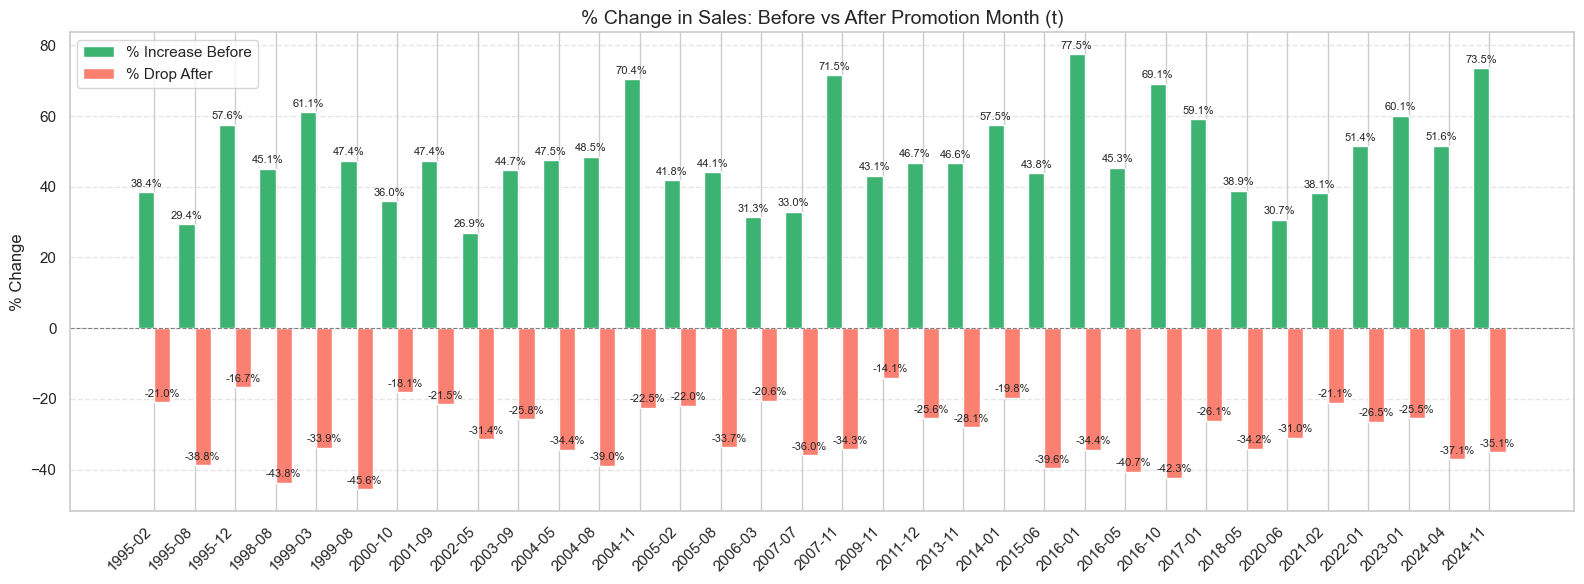

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Tạo x-labels
labels = [f"{int(y)}-{int(m):02d}" for y, m in zip(result['Year'], result['Month'])]
x = np.arange(len(labels))

# Dữ liệu
before = result['Change_%_Before']
after = result['Change_%_After']

# Vẽ bar chart
plt.figure(figsize=(16, 6))
bar1 = plt.bar(x - 0.2, before, width=0.4, label='% Increase Before', color='mediumseagreen')
bar2 = plt.bar(x + 0.2, after, width=0.4, label='% Drop After', color='salmon')

# Gắn nhãn giá trị trên mỗi cột
for i in range(len(x)):
    plt.text(x[i] - 0.2, before.iloc[i] + 1, f"{before.iloc[i]:.1f}%", ha='center', va='bottom', fontsize=8)
    plt.text(x[i] + 0.2, after.iloc[i] + 1, f"{after.iloc[i]:.1f}%", ha='center', va='bottom', fontsize=8)

# Labeling
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('% Change')
plt.title('% Change in Sales: Before vs After Promotion Month (t)', fontsize=14)
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Khuyến mãi giúp tăng doanh số sweater rất hiệu quả trong ngắn hạn, với mức tăng trung bình khá cao.
Tuy nhiên, hiệu ứng này không kéo dài – gần như toàn bộ các tháng sau promo đều chứng kiến doanh số giảm mạnh.

Discount là hình thức duy nhất trong top này, cho thấy khả năng tăng mạnh doanh số ngay tại tháng triển khai.

Các tháng này có thể là dịp đặc biệt (năm mới, cuối năm, sale lớn) khiến discount phát huy tối đa hiệu quả.

Gợi ý: nên tiếp tục đẩy mạnh Discount vào những dịp tương tự, đặc biệt là đầu và cuối năm.




Nhìn chung thì những đợt cuối năm, đầu năm (thu đông) có xu hướng mang lại hiệu quả promo tốt nhất.

In [ ]:


# Copy và xử lý dữ liệu
df = merged_df.copy()
df = df.sort_values(by=['Year', 'Month']).reset_index(drop=True)

# Tạo doanh số tháng trước và sau
df['Sales_t-1'] = df['New_Sales'].shift(1)
df['Sales_t+1'] = df['New_Sales'].shift(-1)

# Gắn promo tháng trước và sau
df['Promo_t'] = df['Promo_Type']
df['Promo_t-1'] = df['Promo_Type'].shift(1)
df['Promo_t+1'] = df['Promo_Type'].shift(-1)

# Chỉ lấy tháng có khuyến mãi
promo_df = df[df['Promo_t'] != 'Non_Promo'].copy()

# Bỏ những dòng thiếu dữ liệu
promo_df = promo_df.dropna(subset=['Sales_t-1', 'Sales_t+1', 'Budget_USD'])

#bỏ promo trước và sau:
promo_df = promo_df[
    (promo_df['Promo_t-1'] == 'Non_Promo') &
    (promo_df['Promo_t+1'] == 'Non_Promo')
].copy()

# Tính % thay đổi trước và sau
promo_df['Change_%_Before'] = ((promo_df['New_Sales'] - promo_df['Sales_t-1']) / promo_df['Sales_t-1']) * 100
promo_df['Change_%_After'] = ((promo_df['Sales_t+1'] - promo_df['New_Sales']) / promo_df['New_Sales']) * 100
promo_df['Month'] = promo_df['Month'].astype(int)

# Phân tích tổng hợp theo loại khuyến mãi
summary = promo_df.groupby('Promo_t').agg({
    'Change_%_Before': ['mean', 'std', 'count'],
    'Change_%_After': ['mean', 'std', 'count'],
    'Month': lambda x: x.value_counts().idxmax()  # Tháng xuất hiện nhiều nhất
}).reset_index()

# Đặt tên cột cho rõ ràng
summary.columns = ['Promo_Type', 
                   'Avg_Change_Before', 'Std_Before', 'Count_Before', 
                   'Avg_Change_After', 'Std_After', 'Count_After',
                   'Most_Common_Month']

# Làm tròn cho dễ đọc
summary[['Avg_Change_Before', 'Avg_Change_After']] = summary[['Avg_Change_Before', 'Avg_Change_After']].round(2)

# Hiển thị kết quả
print(" Phân tích hiệu quả từng loại khuyến mãi:")
display(summary.sort_values(by='Avg_Change_Before', ascending=False))  # Sắp xếp theo hiệu ứng trước khuyến mãi




 Phân tích hiệu quả từng loại khuyến mãi:


,Promo_Type,Avg_Change_Before,Std_Before,Count_Before,Avg_Change_After,Std_After,Count_After,Most_Common_Month
2,Discount,53.79,14.554604,13,-34.15,9.399860,13,8
0,Bundle,47.01,11.040555,18,-27.06,6.831256,18,1
1,Cashback,36.63,13.192420,3,-29.67,8.390645,3,5


Discount giúp tạo "cú hích" tốt nhất nhưng dễ rơi vào tình trạng "đốt lực" nhanh, khó duy trì hiệu quả sau đó. Bundle không tạo cú hích quá mạnh nhưng giữ được độ ổn định sau khuyến mãi tốt nhất → phù hợp cho chiến lược dài hạn

## **AFTER SALES VÀ BEFORE SALES CỦA CÁC THÁNG LIÊN TIẾP CÓ PROMO**

In [ ]:


# Giả sử merged_df đã sẵn sàng và có các cột: Year, Month, New_Sales, Promo_Type
df = merged_df.copy()
df = df.sort_values(by=['Year', 'Month']).reset_index(drop=True)

# Gán chỉ số thời gian
df['Time_ID'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))
df['Has_Promo'] = (df['Promo_Type'] != 'Non_Promo').astype(int)

# Tạo nhóm liên tiếp promo
df['Gap'] = (df['Has_Promo'] != df['Has_Promo'].shift()).cumsum()
df['Promo_Group'] = (df['Has_Promo'] == 1).astype(int) * df['Gap']
df['Promo_Group'] = df['Promo_Group'].replace(0, pd.NA)

# Lọc các chuỗi promo có ít nhất 2 tháng liên tiếp
promo_groups = df.dropna(subset=['Promo_Group']).groupby('Promo_Group').filter(lambda x: len(x) >= 2).reset_index()

# Phân tích chuỗi
result_rows = []

for group_id, group_df in promo_groups.groupby('Promo_Group'):
    group_df = group_df.sort_values('Time_ID')

    idx_first = group_df['index'].iloc[0]
    idx_last = group_df['index'].iloc[-1]

    if idx_first > 0 and idx_last + 1 < len(df):
        prev_sales = df.loc[idx_first - 1, 'New_Sales']
        after_sales = df.loc[idx_last + 1, 'New_Sales']
        during_sales = group_df['New_Sales'].mean()

        change_before = (during_sales - prev_sales) / prev_sales * 100
        change_after = (after_sales - during_sales) / during_sales * 100

        promo_seq = ', '.join(group_df['Promo_Type'].tolist())

        result_rows.append({
            'Promo_Start': df.loc[idx_first, 'Time_ID'],
            'Promo_End': df.loc[idx_last, 'Time_ID'],
            'Promo_Length': len(group_df),
            'Promo_Type_Sequence': promo_seq,
            'Before_Sales': prev_sales,
            'During_Sales_Avg': during_sales,
            'After_Sales': after_sales,
            'Change_%_Before': round(change_before, 2),
            'Change_%_After': round(change_after, 2)
        })

# Tạo DataFrame kết quả
promo_seq_df = pd.DataFrame(result_rows)

# In kết quả
print("🔍 So sánh doanh số trước và sau các chuỗi promo liên tiếp (≥ 2 tháng):")
print(promo_seq_df[['Promo_Start', 'Promo_End', 'Promo_Type_Sequence', 'Change_%_Before', 'Change_%_After']])


🔍 So sánh doanh số trước và sau các chuỗi promo liên tiếp (≥ 2 tháng):
  Promo_Start  Promo_End       Promo_Type_Sequence  Change_%_Before  \
0  1997-10-01 1997-11-01          Bundle, Discount            52.34   
1  1999-05-01 1999-06-01          Bundle, Discount            27.22   
2  2006-08-01 2006-09-01          Discount, Bundle            29.93   
3  2010-03-01 2010-04-01          Bundle, Discount            51.05   
4  2010-12-01 2011-01-01        Discount, Discount            82.03   
5  2011-06-01 2011-07-01          Discount, Bundle            38.35   
6  2015-01-01 2015-03-01  Discount, Bundle, Bundle            55.42   
7  2015-08-01 2015-10-01  Bundle, Discount, Bundle            35.43   
8  2017-09-01 2017-10-01          Discount, Bundle            62.06   

   Change_%_After  
0          -23.67  
1          -34.37  
2          -26.44  
3          -35.85  
4          -29.85  
5          -44.75  
6          -26.47  
7          -29.05  
8          -32.02  


## **SO SÁNH LIÊN TIẾP VS KHÔNG LIÊN TIẾP**

In [ ]:
import pandas as pd

# B1. Chuẩn bị dữ liệu
df = merged_df.copy()
df = df.sort_values(by=['Year', 'Month']).reset_index(drop=True)
df['Time_ID'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))
df['Has_Promo'] = (df['Promo_Type'] != 'Non_Promo').astype(int)

# B2. Tạo group liên tiếp
df['Gap'] = (df['Has_Promo'] != df['Has_Promo'].shift()).cumsum()
df['Promo_Group'] = (df['Has_Promo'] == 1).astype(int) * df['Gap']
df['Promo_Group'] = df['Promo_Group'].replace(0, pd.NA)

# B3. Lấy sales trước và sau
df['Prev_Sales'] = df['New_Sales'].shift(1)
df['Next_Sales'] = df['New_Sales'].shift(-1)
df['Prev_Has_Promo'] = df['Has_Promo'].shift(1)
df['Next_Has_Promo'] = df['Has_Promo'].shift(-1)

# B4. Tạo Group A - chuỗi liên tiếp ≥2 tháng
promo_groups = df.dropna(subset=['Promo_Group']).groupby('Promo_Group').filter(lambda x: len(x) >= 2).reset_index()
promo_seq_rows = []

for group_id, group_df in promo_groups.groupby('Promo_Group'):
    group_df = group_df.sort_values('Time_ID')
    idx_first = group_df['index'].iloc[0]
    idx_last = group_df['index'].iloc[-1]

    if idx_first > 0 and idx_last + 1 < len(df):
        prev_sales = df.loc[idx_first - 1, 'New_Sales']
        after_sales = df.loc[idx_last + 1, 'New_Sales']
        during_sales = group_df['New_Sales'].mean()
        change_before = (during_sales - prev_sales) / prev_sales * 100
        change_after = (after_sales - during_sales) / during_sales * 100

        promo_seq_rows.append({
            'Group': 'Multi',
            'Change_%_Before': change_before,
            'Change_%_After': change_after
        })

group_a_df = pd.DataFrame(promo_seq_rows)

# B5. Tạo Group B - các tháng promo đơn lẻ, xung quanh không có khuyến mãi
mask_single = (
    (df['Has_Promo'] == 1) &
    (df['Prev_Has_Promo'] == 0) &
    (df['Next_Has_Promo'] == 0)
)
single_df = df[mask_single].copy()

single_df['Change_%_Before'] = ((single_df['New_Sales'] - single_df['Prev_Sales']) / single_df['Prev_Sales']) * 100
single_df['Change_%_After'] = ((single_df['Next_Sales'] - single_df['New_Sales']) / single_df['New_Sales']) * 100
single_df['Group'] = 'Single'

group_b_df = single_df[['Change_%_Before', 'Change_%_After', 'Group']]

# B6. Gộp lại để so sánh
compare_df = pd.concat([group_a_df, group_b_df], ignore_index=True)

# B7. Tổng hợp thống kê
summary = compare_df.groupby('Group').agg(
    Avg_Change_Before=('Change_%_Before', 'mean'),
    Std_Before=('Change_%_Before', 'std'),
    Avg_Change_After=('Change_%_After', 'mean'),
    Std_After=('Change_%_After', 'std'),
    Count=('Change_%_Before', 'count')
).round(2)

print(" So sánh hiệu quả doanh số giữa promo liên tiếp và không liên tiếp:")
print(summary)


 So sánh hiệu quả doanh số giữa promo liên tiếp và không liên tiếp:
        Avg_Change_Before  Std_Before  Avg_Change_After  Std_After  Count
Group                                                                    
Multi               48.20       17.49            -31.38       6.36      9
Single              48.69       13.24            -30.00       8.48     34


In [ ]:


# Bước 1: Chuỗi promo liên tiếp (≥2 tháng)
df = merged_df.copy()
df = df.sort_values(by=['Year', 'Month']).reset_index(drop=True)
df['Time_ID'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))
df['Has_Promo'] = (df['Promo_Type'] != 'Non_Promo').astype(int)
df['Gap'] = (df['Has_Promo'] != df['Has_Promo'].shift()).cumsum()
df['Promo_Group'] = (df['Has_Promo'] == 1).astype(int) * df['Gap']
df['Promo_Group'] = df['Promo_Group'].replace(0, pd.NA)

promo_groups = df.dropna(subset=['Promo_Group']).groupby('Promo_Group').filter(lambda x: len(x) >= 2).reset_index()
result_rows = []

for group_id, group_df in promo_groups.groupby('Promo_Group'):
    group_df = group_df.sort_values('Time_ID')
    idx_first = group_df['index'].iloc[0]
    idx_last = group_df['index'].iloc[-1]
    if idx_first > 0 and idx_last + 1 < len(df):
        prev_sales = df.loc[idx_first - 1, 'New_Sales']
        after_sales = df.loc[idx_last + 1, 'New_Sales']
        during_sales = group_df['New_Sales'].mean()
        change_before = (during_sales - prev_sales) / prev_sales * 100
        change_after = (after_sales - during_sales) / during_sales * 100
        result_rows.append({
            'Change_%_Before': round(change_before, 2),
            'Change_%_After': round(change_after, 2)
        })

promo_seq_df = pd.DataFrame(result_rows)
promo_seq_df['Group'] = 'Multi'

# Bước 2: Promo đơn (trước và sau không có promo)
df = merged_df.copy()
df = df.sort_values(by=['Year', 'Month']).reset_index(drop=True)
df['Sales_t-1'] = df['New_Sales'].shift(1)
df['Sales_t+1'] = df['New_Sales'].shift(-1)
df['Promo_t'] = df['Promo_Type']
df['Promo_t-1'] = df['Promo_Type'].shift(1)
df['Promo_t+1'] = df['Promo_Type'].shift(-1)

single_promo_df = df[
    (df['Promo_t'] != 'Non_Promo') &
    (df['Promo_t-1'] == 'Non_Promo') &
    (df['Promo_t+1'] == 'Non_Promo')
].dropna(subset=['Sales_t-1', 'Sales_t+1'])

single_promo_df['Change_%_Before'] = ((single_promo_df['New_Sales'] - single_promo_df['Sales_t-1']) / single_promo_df['Sales_t-1']) * 100
single_promo_df['Change_%_After'] = ((single_promo_df['Sales_t+1'] - single_promo_df['New_Sales']) / single_promo_df['New_Sales']) * 100
single_promo_df['Group'] = 'Single'

# Bước 3: T-test
comparison_df = pd.concat([
    promo_seq_df[['Change_%_Before', 'Change_%_After', 'Group']],
    single_promo_df[['Change_%_Before', 'Change_%_After', 'Group']]
], ignore_index=True)

t_before, p_before = ttest_ind(
    comparison_df[comparison_df['Group'] == 'Multi']['Change_%_Before'],
    comparison_df[comparison_df['Group'] == 'Single']['Change_%_Before'],
    equal_var=False
)
t_after, p_after = ttest_ind(
    comparison_df[comparison_df['Group'] == 'Multi']['Change_%_After'],
    comparison_df[comparison_df['Group'] == 'Single']['Change_%_After'],
    equal_var=False
)

# Thống kê mô tả
summary = comparison_df.groupby('Group').agg({
    'Change_%_Before': ['mean', 'std', 'count'],
    'Change_%_After': ['mean', 'std', 'count']
}).round(2)

print(" So sánh hiệu quả doanh số giữa chuỗi Promo liên tiếp và đơn:")
print(summary)
print("\n T-test kết quả:")
print(f"  ➤ Before Sales Change: t = {t_before:.2f}, p = {p_before:.4f}")
print(f"  ➤ After Sales Change:  t = {t_after:.2f}, p = {p_after:.4f}")


 So sánh hiệu quả doanh số giữa chuỗi Promo liên tiếp và đơn:
       Change_%_Before              Change_%_After            
                  mean    std count           mean   std count
Group                                                         
Multi            48.20  17.49     9         -31.39  6.36     9
Single           48.69  13.24    34         -30.00  8.48    34

 T-test kết quả:
  ➤ Before Sales Change: t = -0.08, p = 0.9398
  ➤ After Sales Change:  t = -0.54, p = 0.5981


Không có bằng chứng thống kê rằng promo liên tiếp hiệu quả hơn promo đơn.

**CORR CỦA SALES T VÀ T-1 ĐÃ LOẠI NO PROMO**

Discount trong mùa thu là lựa chọn có mức tương quan tích cực mạnh mẽ nhất trong toàn bộ bảng. Cần xem xét tăng ngân sách khi triển khai Discount vào mùa này, Bundle là ứng viên tiềm năng mùa hè nếu được đầu tư ngân sách cao, nhưng cần được thử nghiệm thêm do n=3

In [ ]:

# Bước 1: Chuẩn bị dữ liệu
df = merged_df.copy()
df = df.sort_values(by=['Year', 'Month']).reset_index(drop=True)

# Tính doanh số tháng trước
df['Sales_t-1'] = df['New_Sales'].shift(1)
df['Promo_t'] = df['Promo_Type']
df['Promo_t-1'] = df['Promo_Type'].shift(1)

# Loại các tháng không phải promo tại thời điểm t hoặc bị lặp lại (t-1 cũng là promo)
df = df[(df['Promo_t'] != 'Non_Promo') & (df['Promo_t-1'] == 'Non_Promo')]

# Gán mùa
season_mapping = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
}
df['Season'] = df['Month'].map(season_mapping)

# Tính % tăng trưởng doanh số
df['Sales_Growth_%'] = ((df['New_Sales'] - df['Sales_t-1']) / df['Sales_t-1']) * 100

# Bước 2: Tính tương quan theo từng mùa và từng loại khuyến mãi
correlation_season_promo = []

for season in df['Season'].dropna().unique():
    for promo_type in df['Promo_t'].dropna().unique():
        sub = df[(df['Season'] == season) & (df['Promo_t'] == promo_type)].dropna(subset=['Budget_USD', 'Sales_Growth_%'])

        if len(sub) >= 2:
            r, p = pearsonr(sub['Budget_USD'], sub['Sales_Growth_%'])
        else:
            r, p = float('nan'), float('nan')

        correlation_season_promo.append({
            'Season': season,
            'Promo_Type': promo_type,
            'Correlation_r': round(r, 2),
            'p_value': round(p, 4),
            'n_observations': len(sub)
        })

# Bước 3: Xuất kết quả
correlation_df = pd.DataFrame(correlation_season_promo).sort_values(by=['Season', 'Promo_Type'])
print(" Tương quan giữa Budget và % Sales Growth (t vs t-1), theo từng mùa và loại khuyến mãi:")
print(correlation_df)


 Tương quan giữa Budget và % Sales Growth (t vs t-1), theo từng mùa và loại khuyến mãi:
    Season Promo_Type  Correlation_r  p_value  n_observations
6     Fall     Bundle          -0.26   0.6229               6
8     Fall   Cashback            NaN      NaN               0
7     Fall   Discount           0.85   0.0710               5
9   Spring     Bundle           0.71   0.1789               5
11  Spring   Cashback           0.95   0.1975               3
10  Spring   Discount            NaN      NaN               1
3   Summer     Bundle           0.97   0.1662               3
5   Summer   Cashback            NaN      NaN               0
4   Summer   Discount           0.32   0.4324               8
0   Winter     Bundle           0.46   0.2476               8
2   Winter   Cashback            NaN      NaN               0
1   Winter   Discount           0.21   0.7941               4


Ưu tiên dùng Discount vào Fall, và theo dõi thêm.